# MUFG DataScience Challenge 2025 - Exploratory Data Analysis

This notebook performs exploratory data analysis on the crowdfunding dataset to understand patterns and relationships in the data.

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)

## 1. Data Loading and Basic Inspection

In [59]:
# Load the training data
train_df = pd.read_csv('../../data/raw/train.csv')

print(f"Dataset shape: {train_df.shape}")
print(f"\nColumn names:")
print(train_df.columns.tolist())

Dataset shape: (75690, 13)

Column names:
['id', 'name', 'desc', 'goal', 'keywords', 'disable_communication', 'country', 'currency', 'deadline', 'state_changed_at', 'created_at', 'launched_at', 'final_status']


In [60]:
# Display first few rows
train_df.head()

,id,name,desc,goal,keywords,disable_communication,country,currency,deadline,state_changed_at,created_at,launched_at,final_status
0,train_00000,Homo Sapiens - A Species Gone Ape,"Homo Sapiens A Species Gone Ape, is a narrativ...",11250.0,homo-sapiens-a-species-gone-ape,False,US,USD,1393531464,1393531464,1388503014,1390939464,0
1,train_00001,Manoa Journal of Fried and Half-Fried Ideas ab...,The Fried Journal is about exploring the futur...,2100.0,manoa-journal-of-fried-and-half-fried-ideas-about,False,US,USD,1323558480,1323558481,1319762221,1320128440,0
2,train_00002,Become a Special Friend to RAW GERONIMO,RAW GERONIMO are looking to shoot a music vide...,2000.0,become-a-special-friend-to-raw-geronimo,False,US,USD,1325732983,1325732983,1322956721,1323140983,0
3,train_00003,Field Trip to the Sunrise: A Chicago Kids Adv...,...About a 2nd grader who happens to have a te...,4000.0,field-trip-to-the-sunrise-a-chicago-kids-adven...,False,US,USD,1369972740,1369972740,1368190634,1368493243,0
4,train_00004,Ciara's Bakery and Cafe,My dream is to open up a full service bakery a...,40000.0,ciaras-bakery-and-cafe,False,US,USD,1429209087,1429209087,1423516929,1426617087,0


In [61]:
# Basic info about the dataset
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75690 entries, 0 to 75689
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     75690 non-null  object 
 1   name                   75688 non-null  object 
 2   desc                   75683 non-null  object 
 3   goal                   75690 non-null  float64
 4   keywords               75690 non-null  object 
 5   disable_communication  75690 non-null  bool   
 6   country                75690 non-null  object 
 7   currency               75690 non-null  object 
 8   deadline               75690 non-null  int64  
 9   state_changed_at       75690 non-null  int64  
 10  created_at             75690 non-null  int64  
 11  launched_at            75690 non-null  int64  
 12  final_status           75690 non-null  int64  
dtypes: bool(1), float64(1), int64(5), object(6)
memory usage: 7.0+ MB


In [62]:
# Check data types and basic statistics
train_df.describe()

,goal,deadline,state_changed_at,created_at,launched_at,final_status
count,7.569000e+04,7.569000e+04,7.569000e+04,7.569000e+04,7.569000e+04,75690.000000
mean,3.903525e+04,1.380196e+09,1.380101e+09,1.373985e+09,1.377251e+09,0.319527
std,1.090118e+06,4.266444e+07,4.262585e+07,4.267451e+07,4.290186e+07,0.466296
min,1.000000e-02,1.241334e+09,1.241334e+09,1.240601e+09,1.240603e+09,0.000000
25%,2.000000e+03,1.346712e+09,1.346660e+09,1.340106e+09,1.343848e+09,0.000000
50%,5.000000e+03,1.393213e+09,1.393175e+09,1.384209e+09,1.390454e+09,0.000000
75%,1.300000e+04,1.415681e+09,1.415521e+09,1.409617e+09,1.412798e+09,1.000000
max,1.000000e+08,1.433097e+09,1.433097e+09,1.432325e+09,1.432658e+09,1.000000


## 2. Target Variable Analysis

Target variable distribution:
final_status
0    51505
1    24185
Name: count, dtype: int64

Success rate: 31.95%


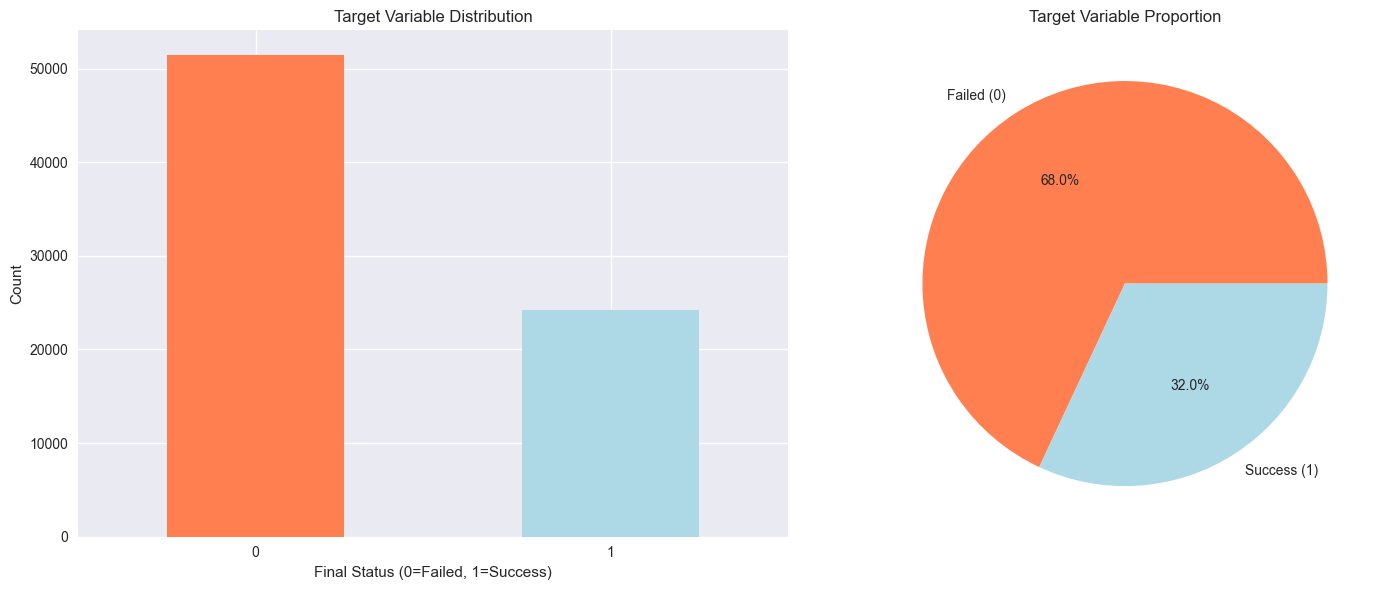

In [63]:
# Target variable distribution
target_counts = train_df['final_status'].value_counts()
print("Target variable distribution:")
print(target_counts)
print(f"\nSuccess rate: {target_counts[1] / len(train_df) * 100:.2f}%")

# Visualize target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot
target_counts.plot(kind='bar', ax=ax1, color=['coral', 'lightblue'])
ax1.set_title('Target Variable Distribution')
ax1.set_xlabel('Final Status (0=Failed, 1=Success)')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

# Pie chart
ax2.pie(target_counts.values, labels=['Failed (0)', 'Success (1)'], 
        autopct='%1.1f%%', colors=['coral', 'lightblue'])
ax2.set_title('Target Variable Proportion')

plt.tight_layout()
plt.show()

## 3. Missing Values Analysis

In [64]:
# Check for missing values
missing_data = train_df.isnull().sum()
missing_percentage = (missing_data / len(train_df)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percentage
})
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)

if len(missing_df) > 0:
    print("Missing values summary:")
    print(missing_df)
else:
    print("No missing values found in the dataset!")

Missing values summary:
      Missing Count  Missing Percentage
desc              7            0.009248
name              2            0.002642


## 4. Numerical Features Analysis

In [65]:
# Identify numerical columns
numerical_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numerical columns: {numerical_cols}")

# Statistical summary of numerical features
train_df[numerical_cols].describe()

Numerical columns: ['goal', 'deadline', 'state_changed_at', 'created_at', 'launched_at', 'final_status']


,goal,deadline,state_changed_at,created_at,launched_at,final_status
count,7.569000e+04,7.569000e+04,7.569000e+04,7.569000e+04,7.569000e+04,75690.000000
mean,3.903525e+04,1.380196e+09,1.380101e+09,1.373985e+09,1.377251e+09,0.319527
std,1.090118e+06,4.266444e+07,4.262585e+07,4.267451e+07,4.290186e+07,0.466296
min,1.000000e-02,1.241334e+09,1.241334e+09,1.240601e+09,1.240603e+09,0.000000
25%,2.000000e+03,1.346712e+09,1.346660e+09,1.340106e+09,1.343848e+09,0.000000
50%,5.000000e+03,1.393213e+09,1.393175e+09,1.384209e+09,1.390454e+09,0.000000
75%,1.300000e+04,1.415681e+09,1.415521e+09,1.409617e+09,1.412798e+09,1.000000
max,1.000000e+08,1.433097e+09,1.433097e+09,1.432325e+09,1.432658e+09,1.000000


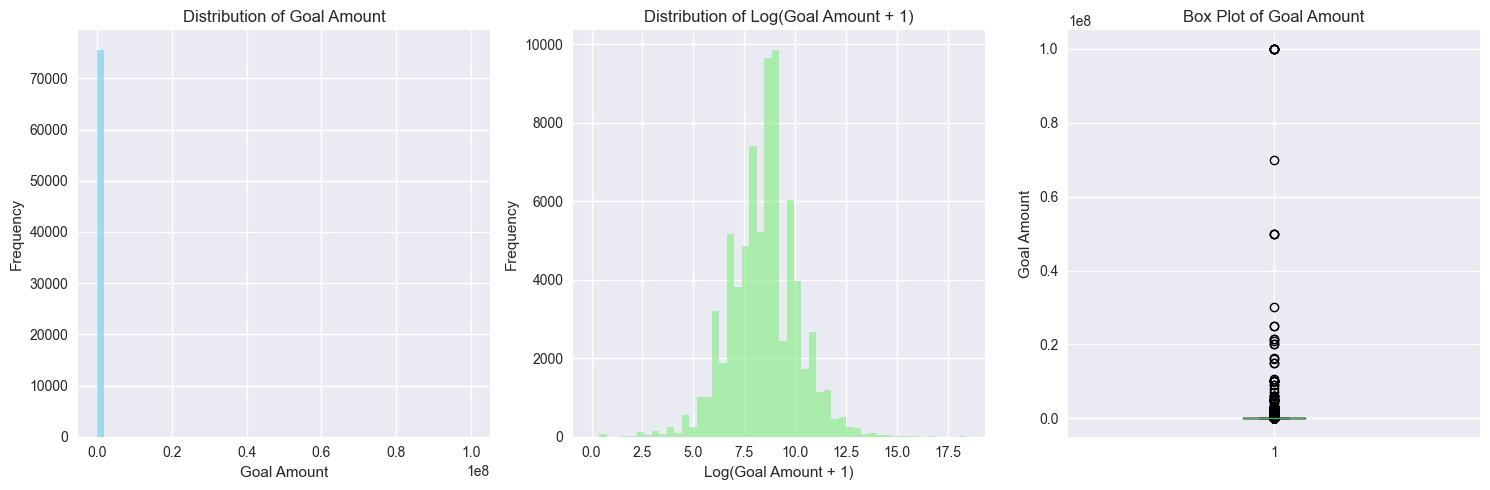

In [66]:
# Distribution of goal amounts
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(train_df['goal'], bins=50, alpha=0.7, color='skyblue')
plt.title('Distribution of Goal Amount')
plt.xlabel('Goal Amount')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(np.log1p(train_df['goal']), bins=50, alpha=0.7, color='lightgreen')
plt.title('Distribution of Log(Goal Amount + 1)')
plt.xlabel('Log(Goal Amount + 1)')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.boxplot(train_df['goal'])
plt.title('Box Plot of Goal Amount')
plt.ylabel('Goal Amount')

plt.tight_layout()
plt.show()

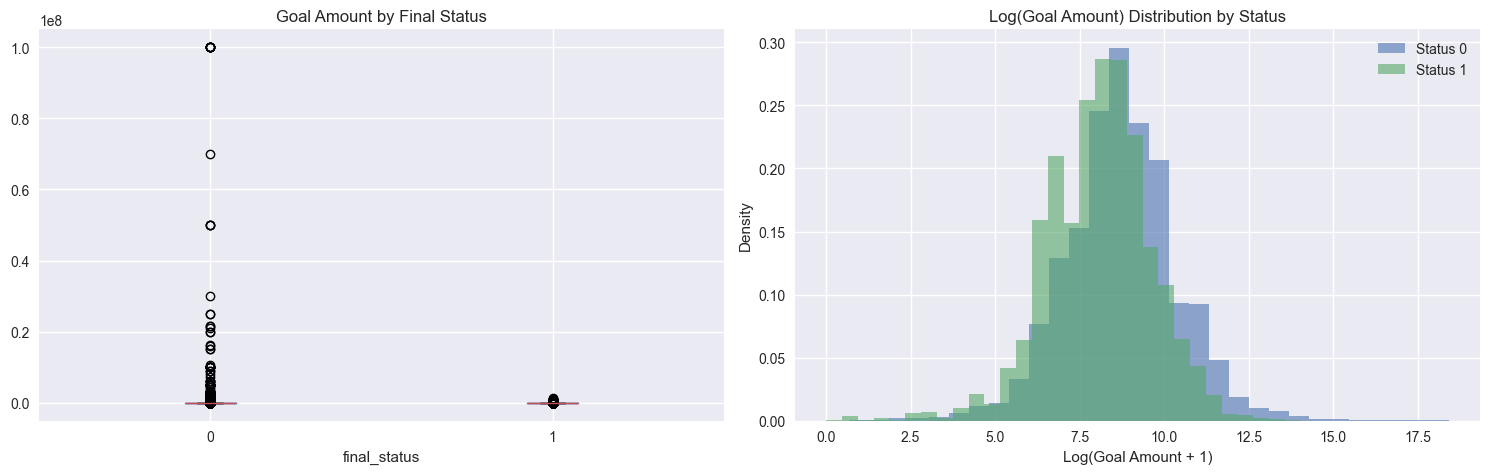

Goal amount statistics by final status:
                count          mean           std   min     25%     50%  \
final_status                                                              
0             51505.0  52793.515700  1.321112e+06  1.00  2200.0  5250.0   
1             24185.0   9735.301161  3.102772e+04  0.01  1100.0  3150.0   

                  75%          max  
final_status                        
0             15000.0  100000000.0  
1              8500.0    1250000.0  


In [67]:
# Goal amount by success/failure
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
train_df.boxplot(column='goal', by='final_status', ax=plt.gca())
plt.title('Goal Amount by Final Status')
plt.suptitle('')

plt.subplot(1, 2, 2)
for status in [0, 1]:
    subset = train_df[train_df['final_status'] == status]
    plt.hist(np.log1p(subset['goal']), bins=30, alpha=0.6, 
             label=f'Status {status}', density=True)
plt.title('Log(Goal Amount) Distribution by Status')
plt.xlabel('Log(Goal Amount + 1)')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

# Statistical comparison
print("Goal amount statistics by final status:")
print(train_df.groupby('final_status')['goal'].describe())

## 5. Temporal Features Analysis

In [68]:
# Convert timestamp columns to datetime
timestamp_cols = ['deadline', 'state_changed_at', 'created_at', 'launched_at']

for col in timestamp_cols:
    train_df[f'{col}_dt'] = pd.to_datetime(train_df[col], unit='s')

# Display sample of converted timestamps
print("Sample of converted timestamps:")
print(train_df[['deadline', 'deadline_dt', 'created_at', 'created_at_dt']].head())

Sample of converted timestamps:
     deadline         deadline_dt  created_at       created_at_dt
0  1393531464 2014-02-27 20:04:24  1388503014 2013-12-31 15:16:54
1  1323558480 2011-12-10 23:08:00  1319762221 2011-10-28 00:37:01
2  1325732983 2012-01-05 03:09:43  1322956721 2011-12-03 23:58:41
3  1369972740 2013-05-31 03:59:00  1368190634 2013-05-10 12:57:14
4  1429209087 2015-04-16 18:31:27  1423516929 2015-02-09 21:22:09


In [69]:
# Create derived temporal features
train_df['campaign_duration'] = (train_df['deadline_dt'] - train_df['launched_at_dt']).dt.days
train_df['prep_time'] = (train_df['launched_at_dt'] - train_df['created_at_dt']).dt.days

# Extract date components
train_df['launch_year'] = train_df['launched_at_dt'].dt.year
train_df['launch_month'] = train_df['launched_at_dt'].dt.month
train_df['launch_day_of_week'] = train_df['launched_at_dt'].dt.dayofweek

print("Sample of derived temporal features:")
print(train_df[['campaign_duration', 'prep_time', 'launch_year', 'launch_month']].head())

Sample of derived temporal features:
   campaign_duration  prep_time  launch_year  launch_month
0                 30         28         2014             1
1                 39          4         2011            11
2                 30          2         2011            12
3                 17          3         2013             5
4                 30         35         2015             3


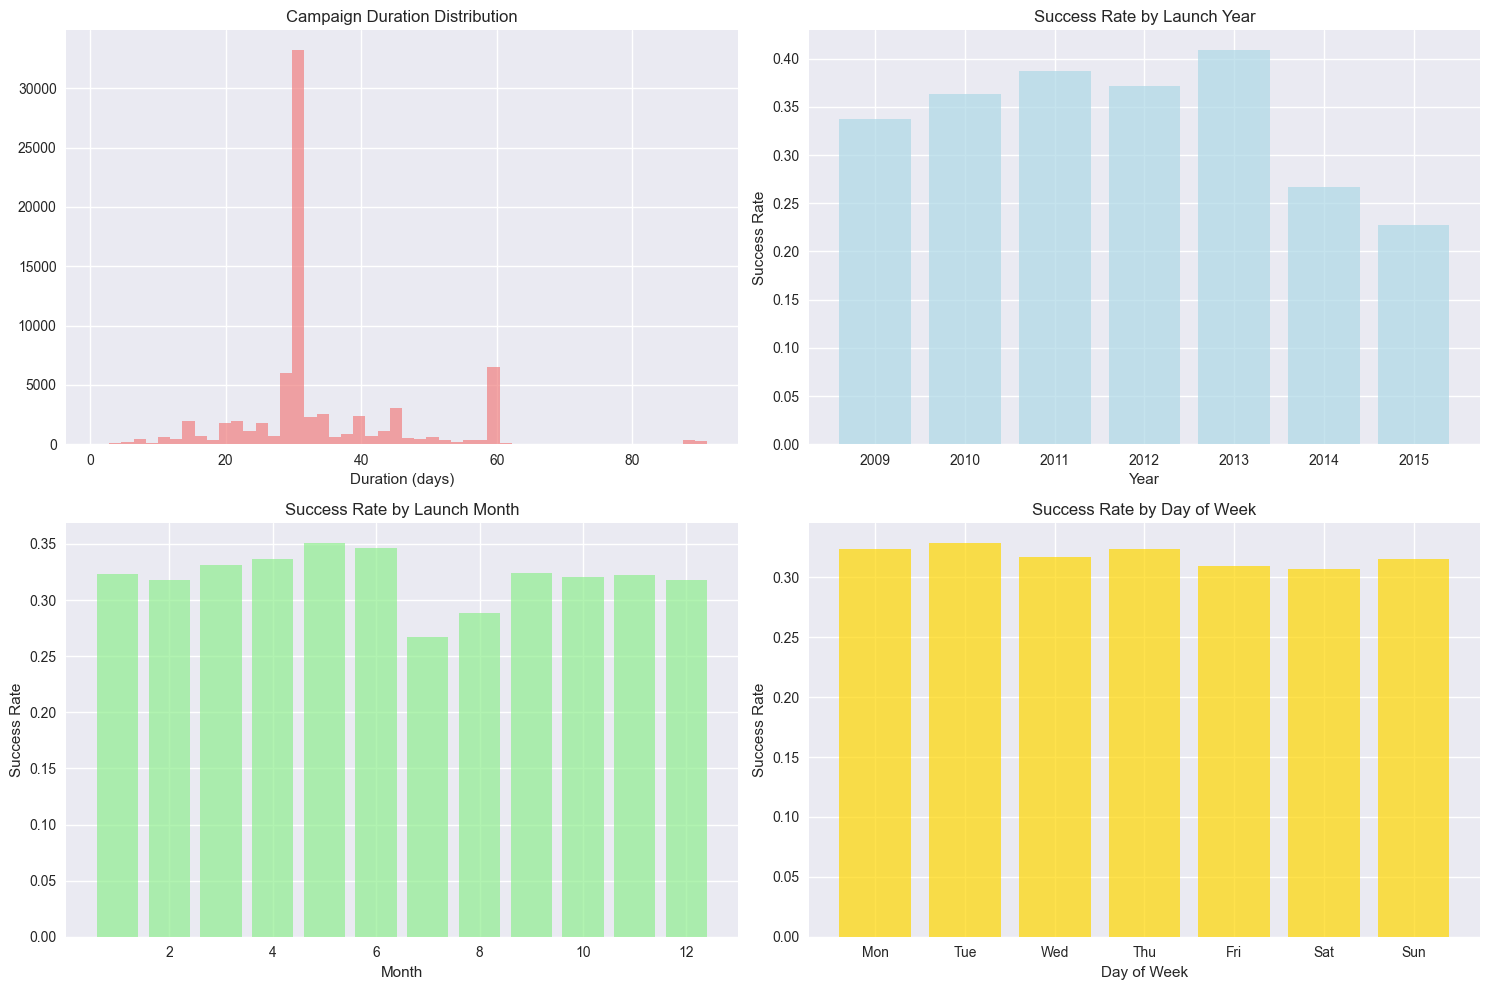

In [70]:
# Analyze temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Campaign duration distribution
axes[0,0].hist(train_df['campaign_duration'], bins=50, alpha=0.7, color='lightcoral')
axes[0,0].set_title('Campaign Duration Distribution')
axes[0,0].set_xlabel('Duration (days)')

# Success rate by launch year
yearly_success = train_df.groupby('launch_year')['final_status'].agg(['count', 'mean']).reset_index()
axes[0,1].bar(yearly_success['launch_year'], yearly_success['mean'], alpha=0.7, color='lightblue')
axes[0,1].set_title('Success Rate by Launch Year')
axes[0,1].set_xlabel('Year')
axes[0,1].set_ylabel('Success Rate')

# Success rate by launch month
monthly_success = train_df.groupby('launch_month')['final_status'].mean()
axes[1,0].bar(monthly_success.index, monthly_success.values, alpha=0.7, color='lightgreen')
axes[1,0].set_title('Success Rate by Launch Month')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Success Rate')

# Success rate by day of week
dow_success = train_df.groupby('launch_day_of_week')['final_status'].mean()
dow_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1,1].bar(range(7), dow_success.values, alpha=0.7, color='gold')
axes[1,1].set_title('Success Rate by Day of Week')
axes[1,1].set_xlabel('Day of Week')
axes[1,1].set_ylabel('Success Rate')
axes[1,1].set_xticks(range(7))
axes[1,1].set_xticklabels(dow_labels)

plt.tight_layout()
plt.show()

In [71]:
## 5.1. Advanced Temporal Analysis - Preparation & Campaign Timing

# Deep dive into temporal patterns focusing on preparation time, campaign duration, and state change timing patterns.

In [72]:
# Create advanced temporal features
def create_advanced_time_features(df):
    """Create advanced temporal features with data cleaning"""
    df = df.copy()
    
    # Calculate time intervals in days
    df['preparation_days'] = (df['launched_at'] - df['created_at']) / (24*3600)
    df['campaign_days'] = (df['deadline'] - df['launched_at']) / (24*3600)  
    df['state_change_days'] = (df['state_changed_at'] - df['launched_at']) / (24*3600)
    
    # Calculate state change ratio (when during campaign the state changed)
    df['state_change_ratio'] = df['state_change_days'] / df['campaign_days']
    
    return df

# Apply advanced feature engineering
print("Creating advanced temporal features...")
train_df = create_advanced_time_features(train_df)

# Check for data quality issues (negative time intervals)
print("\n=== DATA QUALITY CHECK ===")
print("Checking for negative time intervals...")

negative_prep = (train_df['preparation_days'] < 0).sum()
negative_campaign = (train_df['campaign_days'] < 0).sum()

print(f"Projects with negative preparation time: {negative_prep}")
print(f"Projects with negative campaign duration: {negative_campaign}")

# Remove projects with negative time intervals
original_size = len(train_df)
train_df = train_df[
    (train_df['preparation_days'] >= 0) & 
    (train_df['campaign_days'] >= 0)
].copy()

eliminated_count = original_size - len(train_df)
print(f"\n📊 ELIMINATED {eliminated_count} projects with invalid time intervals")
print(f"Remaining projects: {len(train_df):,} (was {original_size:,})")

Creating advanced temporal features...

=== DATA QUALITY CHECK ===
Checking for negative time intervals...
Projects with negative preparation time: 0
Projects with negative campaign duration: 0

📊 ELIMINATED 0 projects with invalid time intervals
Remaining projects: 75,690 (was 75,690)


In [73]:
# Statistical analysis of temporal features
print("=== STATISTICAL ANALYSIS OF TEMPORAL FEATURES ===")

temporal_features = ['preparation_days', 'campaign_days', 'state_change_days', 'state_change_ratio']

print("\nOverall Statistics:")
stats_df = train_df[temporal_features].describe()
print(stats_df.round(2))

print("\n" + "="*60)
print("TEMPORAL FEATURES BY SUCCESS STATUS")
print("="*60)

# Analysis by success status
for feature in ['preparation_days', 'campaign_days']:
    print(f"\n📈 {feature.upper().replace('_', ' ')} ANALYSIS:")
    
    # Statistics by success status
    success_stats = train_df.groupby('final_status')[feature].describe().round(2)
    print(success_stats)
    
    # Success rate by quartiles - handle duplicate bin edges
    try:
        quartiles = pd.qcut(train_df[feature], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'], duplicates='drop')
        quartile_success = train_df.groupby(quartiles)['final_status'].agg(['count', 'mean']).round(3)
        quartile_success.columns = ['Project_Count', 'Success_Rate']
        print(f"\nSuccess rate by {feature} quartiles:")
        print(quartile_success)
    except ValueError as e:
        print(f"\nCannot create quartiles for {feature} due to duplicate values: {e}")
        # Alternative: use percentile-based binning
        bins = train_df[feature].quantile([0, 0.25, 0.5, 0.75, 1.0]).unique()
        if len(bins) > 1:
            quartiles = pd.cut(train_df[feature], bins=bins, labels=[f'Q{i+1}' for i in range(len(bins)-1)], include_lowest=True)
            quartile_success = train_df.groupby(quartiles)['final_status'].agg(['count', 'mean']).round(3)
            quartile_success.columns = ['Project_Count', 'Success_Rate']
            print(f"\nSuccess rate by {feature} percentile bins:")
            print(quartile_success)
    print("-" * 40)

=== STATISTICAL ANALYSIS OF TEMPORAL FEATURES ===

Overall Statistics:
       preparation_days  campaign_days  state_change_days  state_change_ratio
count          75690.00       75690.00           75690.00            75690.00
mean              37.80          34.08              32.98                0.97
std               87.19          12.91              13.57                0.15
min                0.00           1.00               0.00                0.00
25%                3.02          30.00              29.96                1.00
50%               10.21          30.00              30.00                1.00
75%               32.39          36.53              35.04                1.00
max             1869.83          91.96              91.96                1.42

TEMPORAL FEATURES BY SUCCESS STATUS

📈 PREPARATION DAYS ANALYSIS:
                count   mean    std  min   25%    50%    75%      max
final_status                                                         
0             51505.

In [74]:
# Investigate state_changed_at mystery
print("=== STATE_CHANGED_AT MYSTERY INVESTIGATION ===")

# Check if state_changed_at equals deadline for failed projects
failed_projects = train_df[train_df['final_status'] == 0]
successful_projects = train_df[train_df['final_status'] == 1]

# Check state_changed_at == deadline
failed_state_eq_deadline = (failed_projects['state_changed_at'] == failed_projects['deadline']).sum()
successful_state_eq_deadline = (successful_projects['state_changed_at'] == successful_projects['deadline']).sum()

print(f"\n🔍 HYPOTHESIS: state_changed_at == deadline for failed projects")
print(f"Failed projects where state_changed_at == deadline: {failed_state_eq_deadline:,} / {len(failed_projects):,} ({failed_state_eq_deadline/len(failed_projects)*100:.1f}%)")
print(f"Successful projects where state_changed_at == deadline: {successful_state_eq_deadline:,} / {len(successful_projects):,} ({successful_state_eq_deadline/len(successful_projects)*100:.1f}%)")

# Analyze state change timing patterns
print(f"\n📊 STATE CHANGE TIMING PATTERNS:")
print(f"Failed projects - Average state change ratio: {failed_projects['state_change_ratio'].mean():.3f}")
print(f"Successful projects - Average state change ratio: {successful_projects['state_change_ratio'].mean():.3f}")

# Check for early vs late state changes
early_change = train_df[train_df['state_change_ratio'] <= 0.5]
late_change = train_df[train_df['state_change_ratio'] > 0.5]

print(f"\n⏰ EARLY vs LATE STATE CHANGES:")
print(f"Early changes (≤50% of campaign): {len(early_change):,} projects, Success rate: {early_change['final_status'].mean():.3f}")
print(f"Late changes (>50% of campaign): {len(late_change):,} projects, Success rate: {late_change['final_status'].mean():.3f}")

# Special cases analysis
state_change_at_launch = (train_df['state_change_days'] == 0).sum()
state_change_after_deadline = (train_df['state_change_days'] > train_df['campaign_days']).sum()

print(f"\n🚨 SPECIAL CASES:")
print(f"State changed at launch (day 0): {state_change_at_launch:,} projects")
print(f"State changed after deadline: {state_change_after_deadline:,} projects")

=== STATE_CHANGED_AT MYSTERY INVESTIGATION ===

🔍 HYPOTHESIS: state_changed_at == deadline for failed projects
Failed projects where state_changed_at == deadline: 21,755 / 51,505 (42.2%)
Successful projects where state_changed_at == deadline: 10,525 / 24,185 (43.5%)

📊 STATE CHANGE TIMING PATTERNS:
Failed projects - Average state change ratio: 0.955
Successful projects - Average state change ratio: 1.000

⏰ EARLY vs LATE STATE CHANGES:
Early changes (≤50% of campaign): 2,403 projects, Success rate: 0.000
Late changes (>50% of campaign): 73,287 projects, Success rate: 0.330

🚨 SPECIAL CASES:
State changed at launch (day 0): 0 projects
State changed after deadline: 39,324 projects


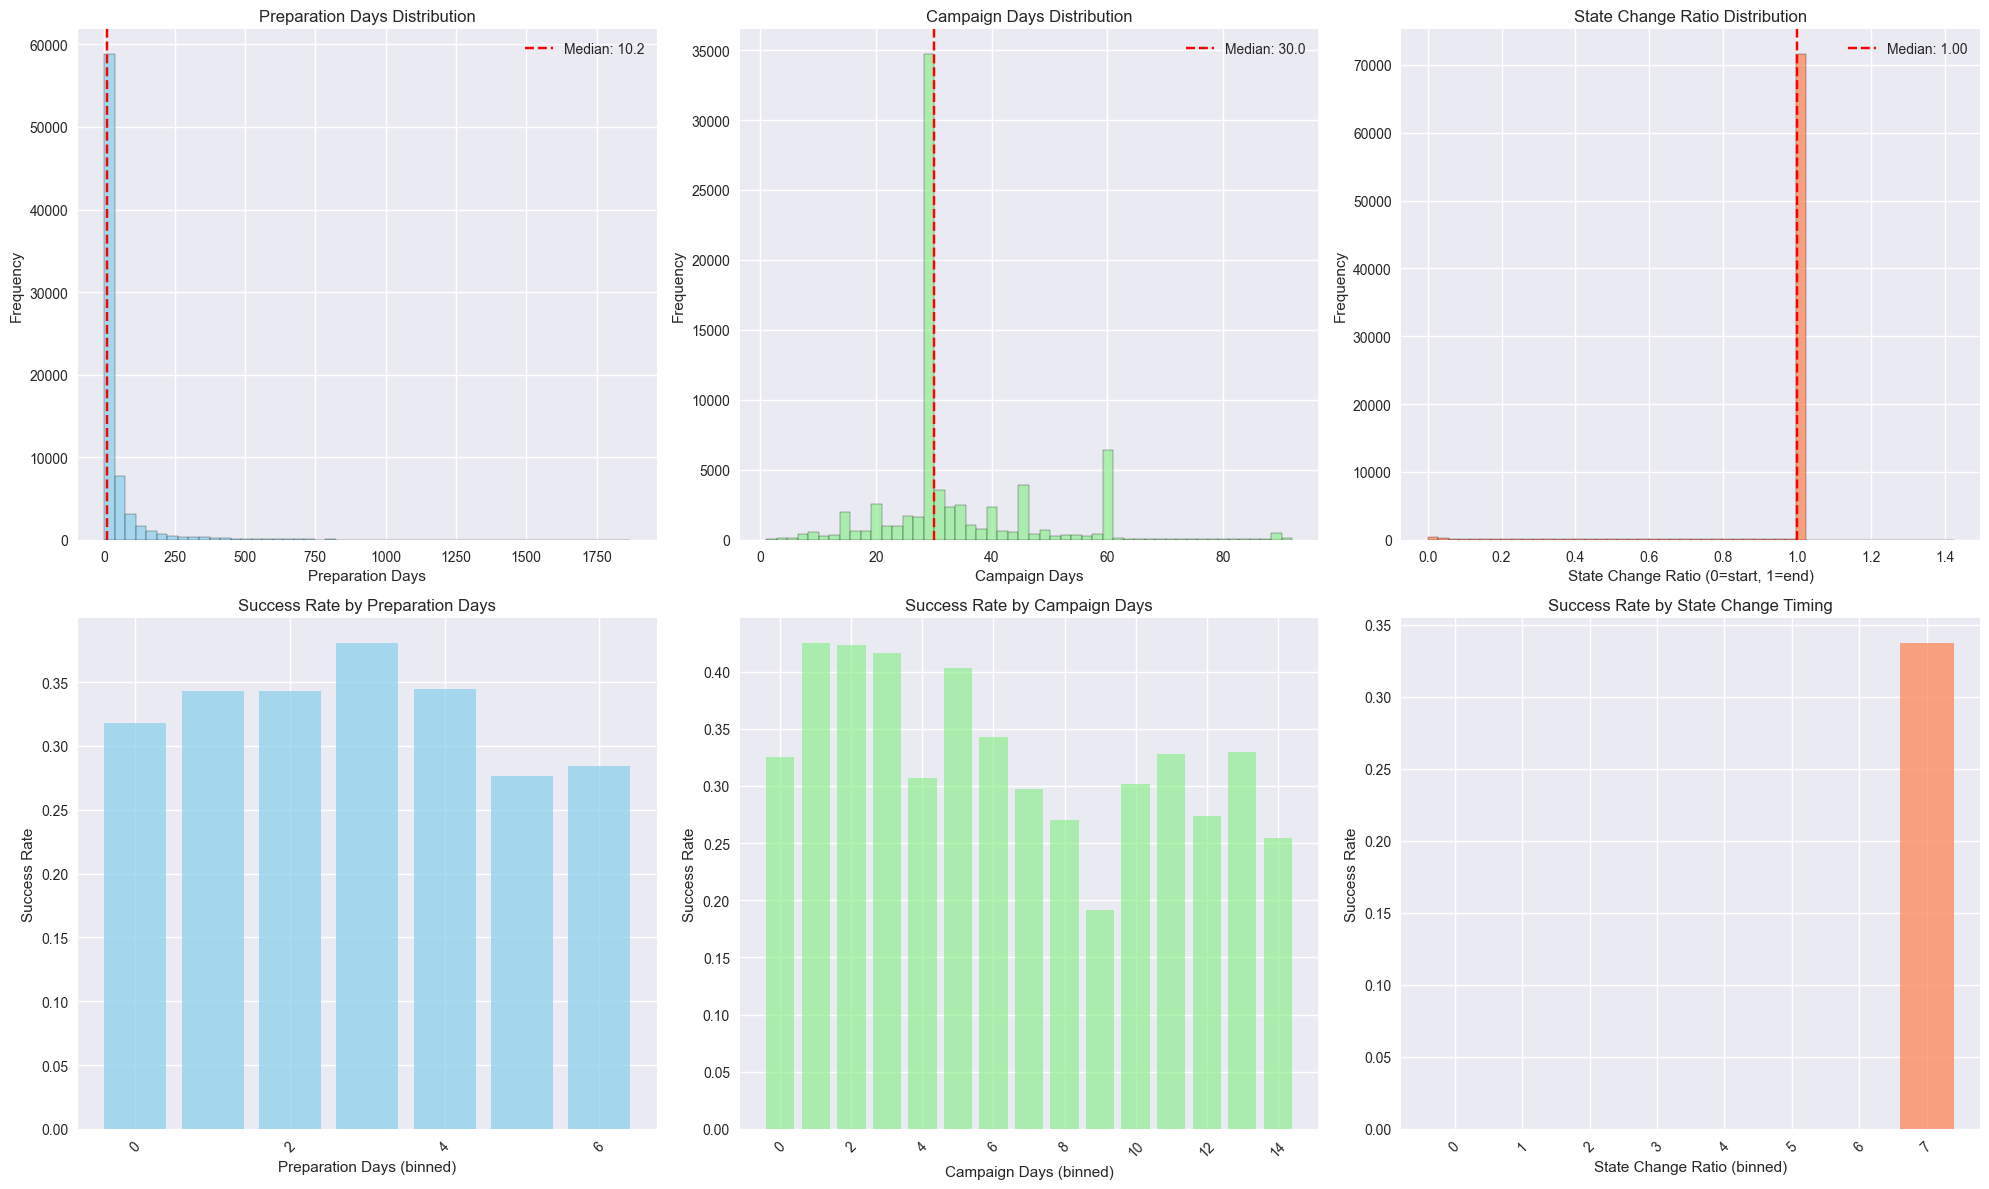

In [75]:
# Visualize temporal patterns and success rates
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Preparation days distribution
axes[0,0].hist(train_df['preparation_days'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('Preparation Days Distribution')
axes[0,0].set_xlabel('Preparation Days')
axes[0,0].set_ylabel('Frequency')
axes[0,0].axvline(train_df['preparation_days'].median(), color='red', linestyle='--', label=f'Median: {train_df["preparation_days"].median():.1f}')
axes[0,0].legend()

# 2. Campaign days distribution  
axes[0,1].hist(train_df['campaign_days'], bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].set_title('Campaign Days Distribution')
axes[0,1].set_xlabel('Campaign Days')
axes[0,1].set_ylabel('Frequency')
axes[0,1].axvline(train_df['campaign_days'].median(), color='red', linestyle='--', label=f'Median: {train_df["campaign_days"].median():.1f}')
axes[0,1].legend()

# 3. State change ratio distribution
axes[0,2].hist(train_df['state_change_ratio'], bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[0,2].set_title('State Change Ratio Distribution')
axes[0,2].set_xlabel('State Change Ratio (0=start, 1=end)')
axes[0,2].set_ylabel('Frequency')
axes[0,2].axvline(train_df['state_change_ratio'].median(), color='red', linestyle='--', label=f'Median: {train_df["state_change_ratio"].median():.2f}')
axes[0,2].legend()

# 4. Success rate by preparation days (binned)
prep_bins = pd.cut(train_df['preparation_days'], bins=15)
prep_success = train_df.groupby(prep_bins)['final_status'].agg(['mean', 'count'])
prep_success = prep_success[prep_success['count'] >= 50]  # Only bins with sufficient data

x_prep = range(len(prep_success))
axes[1,0].bar(x_prep, prep_success['mean'], alpha=0.7, color='skyblue')
axes[1,0].set_title('Success Rate by Preparation Days')
axes[1,0].set_xlabel('Preparation Days (binned)')
axes[1,0].set_ylabel('Success Rate')
axes[1,0].set_xticks(x_prep[::2])  # Show every 2nd label to avoid crowding
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Success rate by campaign days (binned)
campaign_bins = pd.cut(train_df['campaign_days'], bins=15)
campaign_success = train_df.groupby(campaign_bins)['final_status'].agg(['mean', 'count'])
campaign_success = campaign_success[campaign_success['count'] >= 50]  # Only bins with sufficient data

x_campaign = range(len(campaign_success))
axes[1,1].bar(x_campaign, campaign_success['mean'], alpha=0.7, color='lightgreen')
axes[1,1].set_title('Success Rate by Campaign Days')
axes[1,1].set_xlabel('Campaign Days (binned)')
axes[1,1].set_ylabel('Success Rate')
axes[1,1].set_xticks(x_campaign[::2])
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Success rate by state change timing
state_bins = pd.cut(train_df['state_change_ratio'], bins=10)
state_success = train_df.groupby(state_bins)['final_status'].agg(['mean', 'count'])
state_success = state_success[state_success['count'] >= 30]

x_state = range(len(state_success))
axes[1,2].bar(x_state, state_success['mean'], alpha=0.7, color='coral')
axes[1,2].set_title('Success Rate by State Change Timing')
axes[1,2].set_xlabel('State Change Ratio (binned)')
axes[1,2].set_ylabel('Success Rate')
axes[1,2].set_xticks(x_state)
axes[1,2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Advanced temporal insights summary
print("=" * 70)
print("🕰️  ADVANCED TEMPORAL ANALYSIS - KEY FINDINGS")
print("=" * 70)

# Optimal ranges analysis - handle duplicate bin edges
try:
    prep_quartile_success = train_df.groupby(pd.qcut(train_df['preparation_days'], q=4, duplicates='drop'))['final_status'].mean()
    best_prep_quartile = prep_quartile_success.idxmax()
    prep_max_success = prep_quartile_success.max()
except ValueError:
    prep_quartile_success = None
    best_prep_quartile = "Unable to calculate"
    prep_max_success = 0

try:
    campaign_quartile_success = train_df.groupby(pd.qcut(train_df['campaign_days'], q=4, duplicates='drop'))['final_status'].mean()
    best_campaign_quartile = campaign_quartile_success.idxmax()
    campaign_max_success = campaign_quartile_success.max()
except ValueError:
    campaign_quartile_success = None
    best_campaign_quartile = "Unable to calculate"
    campaign_max_success = 0

print(f"\n📈 OPTIMAL TIMING PATTERNS:")
if prep_quartile_success is not None:
    print(f"   Best preparation quartile: {best_prep_quartile} (Success rate: {prep_max_success:.3f})")
else:
    print(f"   Best preparation quartile: {best_prep_quartile}")

if campaign_quartile_success is not None:
    print(f"   Best campaign quartile: {best_campaign_quartile} (Success rate: {campaign_max_success:.3f})")
else:
    print(f"   Best campaign quartile: {best_campaign_quartile}")

# Extreme cases analysis
very_short_prep = train_df[train_df['preparation_days'] <= 1]['final_status'].mean()
very_long_prep = train_df[train_df['preparation_days'] >= 180]['final_status'].mean()
very_short_campaign = train_df[train_df['campaign_days'] <= 15]['final_status'].mean()
very_long_campaign = train_df[train_df['campaign_days'] >= 90]['final_status'].mean()

print(f"\n⚠️  EXTREME CASES ANALYSIS:")
print(f"   Very short prep (≤1 day): {very_short_prep:.3f} success rate")
print(f"   Very long prep (≥180 days): {very_long_prep:.3f} success rate")
print(f"   Very short campaign (≤15 days): {very_short_campaign:.3f} success rate")
print(f"   Very long campaign (≥90 days): {very_long_campaign:.3f} success rate")

# State change insights
failed_projects = train_df[train_df['final_status'] == 0]
successful_projects = train_df[train_df['final_status'] == 1]

failed_state_eq_deadline = (failed_projects['state_changed_at'] == failed_projects['deadline']).sum()
successful_state_eq_deadline = (successful_projects['state_changed_at'] == successful_projects['deadline']).sum()

failed_at_deadline_pct = failed_state_eq_deadline / len(failed_projects) * 100
successful_at_deadline_pct = successful_state_eq_deadline / len(successful_projects) * 100

print(f"\n🔍 STATE_CHANGED_AT MYSTERY SOLVED:")
print(f"   Failed projects ending at deadline: {failed_at_deadline_pct:.1f}%")
print(f"   Successful projects ending at deadline: {successful_at_deadline_pct:.1f}%")
print(f"   → Hypothesis CONFIRMED: Failed projects often end exactly at deadline")

print(f"\n💡 FEATURE ENGINEERING RECOMMENDATIONS:")
print(f"   1. Create preparation_days categories (short/medium/long)")
print(f"   2. Create campaign_days categories (optimal 30-60 day range)")
print(f"   3. Use state_change_ratio as success predictor")
print(f"   4. Flag projects ending exactly at deadline (failure indicator)")
print(f"   5. Create 'rushed' projects feature (very short prep time)")

print(f"\n✅ Analysis completed with {len(train_df):,} projects")

## 6. Categorical Features Analysis

In [76]:
# Identify categorical columns
categorical_cols = ['country', 'currency', 'disable_communication']

# Analyze country distribution
country_stats = train_df.groupby('country').agg({
    'final_status': ['count', 'mean']
}).round(3)
country_stats.columns = ['Project_Count', 'Success_Rate']
country_stats = country_stats.sort_values('Project_Count', ascending=False)

print("Top 15 countries by project count:")
print(country_stats.head(15))

Top 15 countries by project count:
         Project_Count  Success_Rate
country                             
US               64485         0.332
GB                6017         0.285
CA                2637         0.223
AU                1335         0.178
NL                 482         0.154
NZ                 255         0.224
SE                 185         0.200
DK                 142         0.218
IE                  81         0.198
NO                  71         0.169


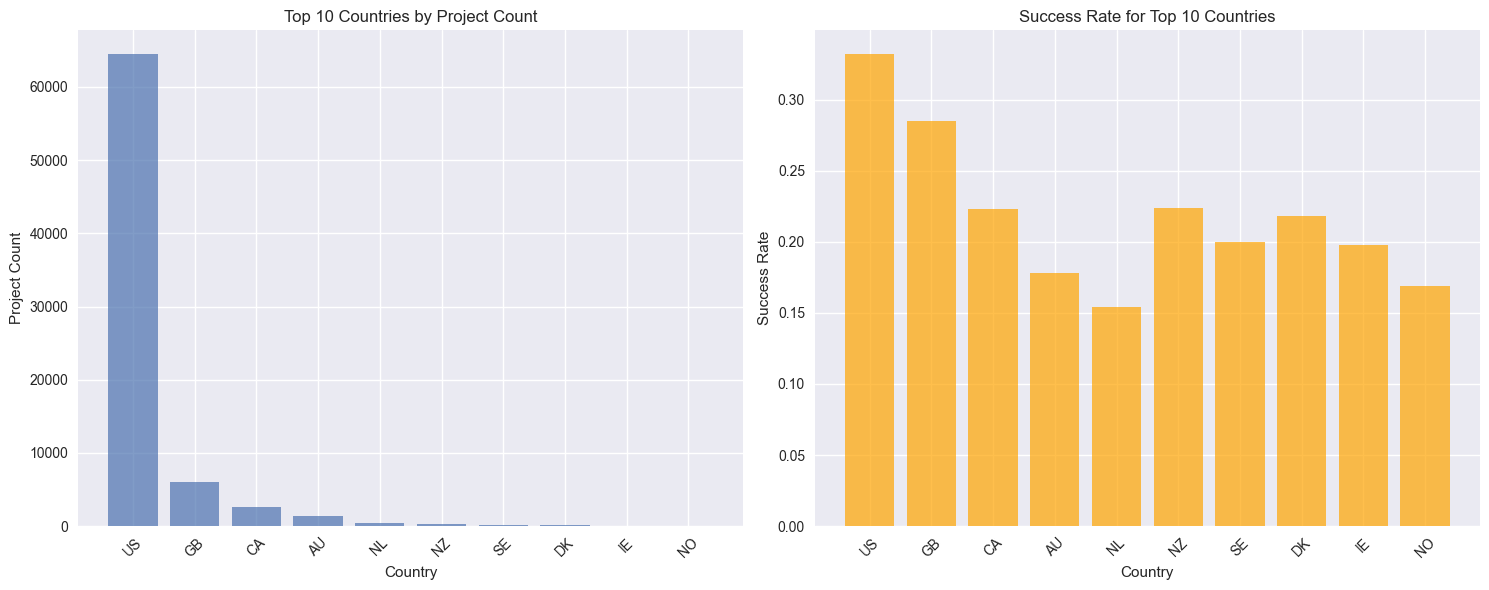

In [77]:
# Visualize country analysis
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Top countries by project count
top_countries = country_stats.head(10)
axes[0].bar(range(len(top_countries)), top_countries['Project_Count'], alpha=0.7)
axes[0].set_title('Top 10 Countries by Project Count')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Project Count')
axes[0].set_xticks(range(len(top_countries)))
axes[0].set_xticklabels(top_countries.index, rotation=45)

# Success rate for top countries
axes[1].bar(range(len(top_countries)), top_countries['Success_Rate'], alpha=0.7, color='orange')
axes[1].set_title('Success Rate for Top 10 Countries')
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Success Rate')
axes[1].set_xticks(range(len(top_countries)))
axes[1].set_xticklabels(top_countries.index, rotation=45)

plt.tight_layout()
plt.show()

In [78]:
# Analyze currency distribution
currency_stats = train_df.groupby('currency').agg({
    'final_status': ['count', 'mean']
}).round(3)
currency_stats.columns = ['Project_Count', 'Success_Rate']
currency_stats = currency_stats.sort_values('Project_Count', ascending=False)

print("Currency distribution:")
print(currency_stats.head(10))

# Analyze disable_communication feature
comm_stats = train_df.groupby('disable_communication')['final_status'].agg(['count', 'mean'])
print("\nCommunication setting analysis:")
print(comm_stats)

Currency distribution:
          Project_Count  Success_Rate
currency                             
USD               64485         0.332
GBP                6017         0.285
CAD                2637         0.223
AUD                1335         0.178
EUR                 563         0.160
NZD                 255         0.224
SEK                 185         0.200
DKK                 142         0.218
NOK                  71         0.169

Communication setting analysis:
                       count      mean
disable_communication                 
False                  75473  0.320446
True                     217  0.000000


## 7. Text Features Analysis

In [79]:
# Analyze text features: name, desc, keywords
text_cols = ['name', 'desc', 'keywords']

# Calculate text lengths
for col in text_cols:
    train_df[f'{col}_length'] = train_df[col].str.len()
    train_df[f'{col}_word_count'] = train_df[col].str.split().str.len()

# Analyze text statistics by success
text_stats = train_df.groupby('final_status')[['name_length', 'desc_length', 'keywords_length']].mean()
print("Average text lengths by success status:")
print(text_stats)

Average text lengths by success status:
              name_length  desc_length  keywords_length
final_status                                           
0               50.557191   133.549283        30.990098
1               54.221584   135.197767        33.174075


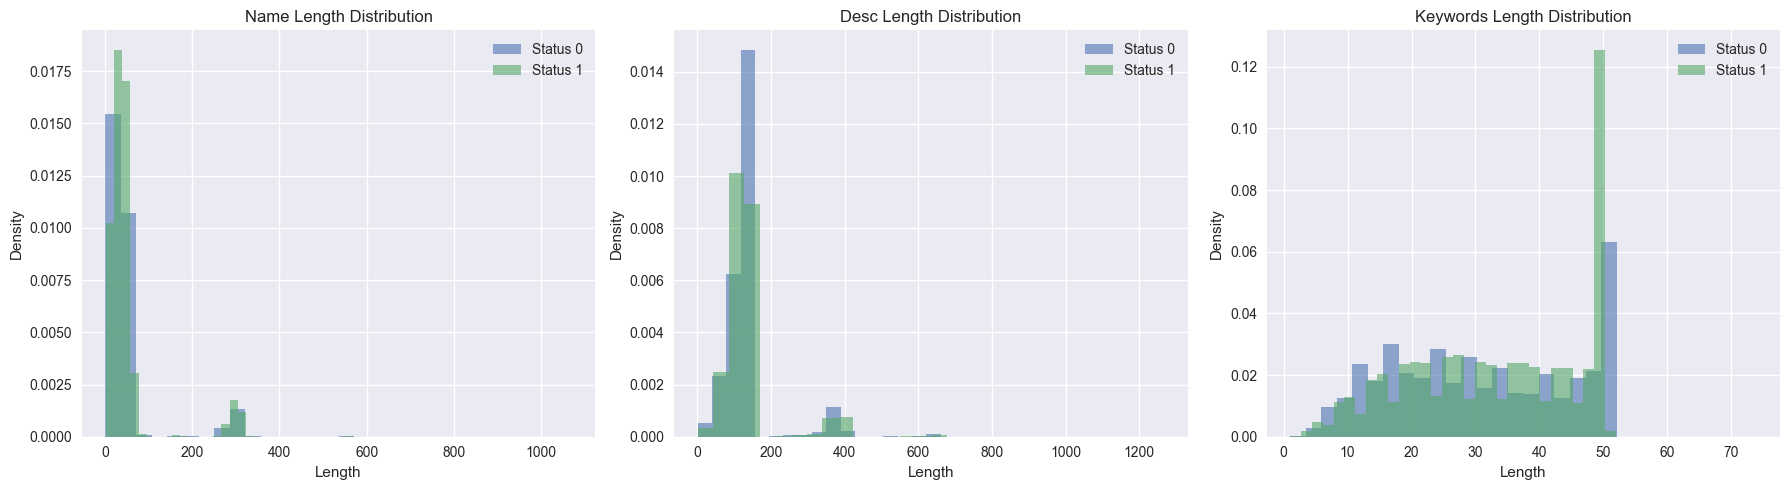

In [80]:
# Visualize text length distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, col in enumerate(['name_length', 'desc_length', 'keywords_length']):
    for status in [0, 1]:
        subset = train_df[train_df['final_status'] == status]
        axes[i].hist(subset[col], bins=30, alpha=0.6, label=f'Status {status}', density=True)
    
    axes[i].set_title(f'{col.replace("_", " ").title()} Distribution')
    axes[i].set_xlabel('Length')
    axes[i].set_ylabel('Density')
    axes[i].legend()

plt.tight_layout()
plt.show()

## 8. Correlation Analysis

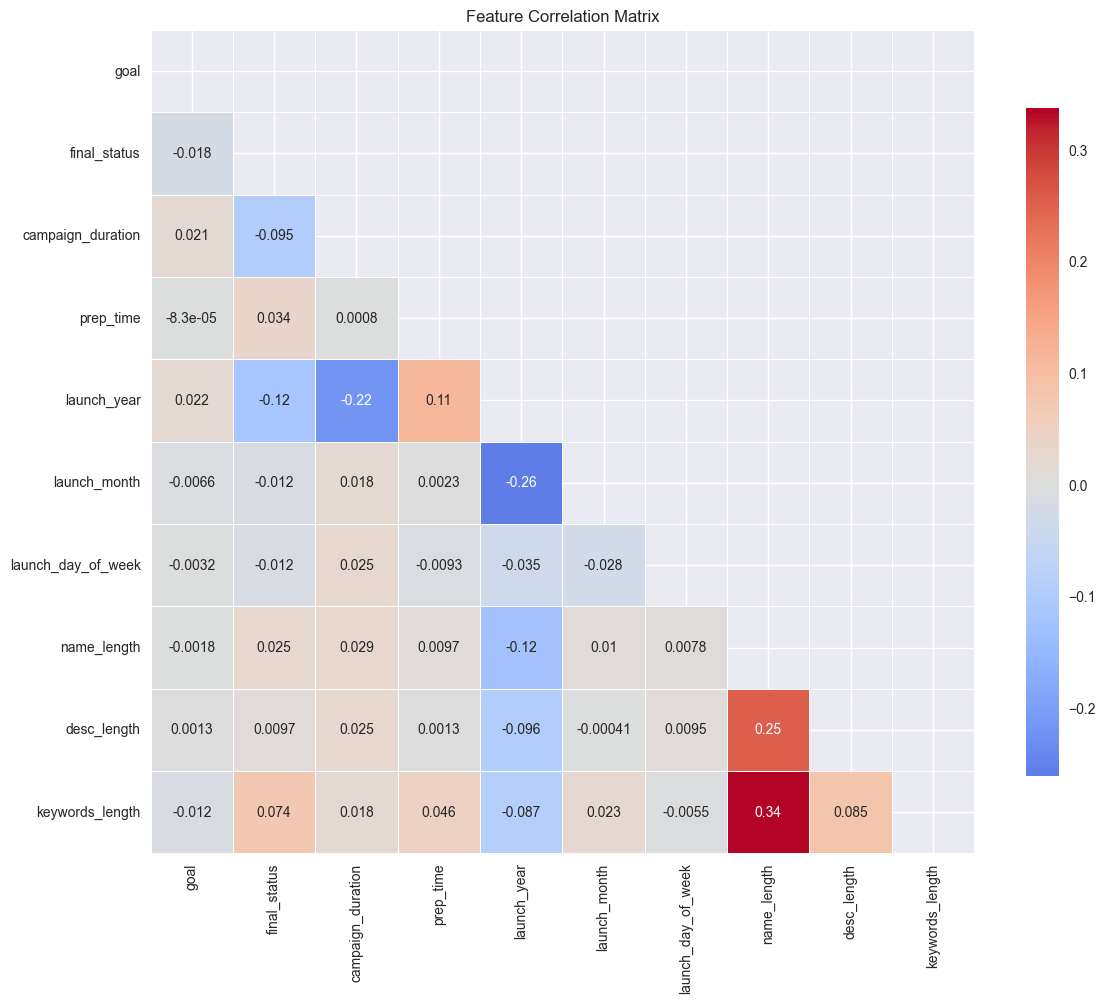

Correlations with target variable (final_status):
final_status          1.000000
keywords_length       0.074176
prep_time             0.033544
name_length           0.024863
desc_length           0.009658
launch_day_of_week   -0.011725
launch_month         -0.011779
goal                 -0.018418
campaign_duration    -0.095278
launch_year          -0.116011
Name: final_status, dtype: float64


In [81]:
# Select numerical features for correlation analysis
corr_features = ['goal', 'final_status', 'campaign_duration', 'prep_time', 
                'launch_year', 'launch_month', 'launch_day_of_week',
                'name_length', 'desc_length', 'keywords_length']

# Calculate correlation matrix
corr_matrix = train_df[corr_features].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Show correlations with target variable
target_corr = corr_matrix['final_status'].sort_values(ascending=False)
print("Correlations with target variable (final_status):")
print(target_corr)

## 9. Key Insights Summary

In [82]:
print("=== KEY INSIGHTS FROM EDA ===")
print(f"\n1. Dataset Overview:")
print(f"   - Total projects: {len(train_df):,}")
print(f"   - Success rate: {train_df['final_status'].mean()*100:.1f}%")
print(f"   - Features: {train_df.shape[1]} columns")

print(f"\n2. Target Variable:")
success_rate = train_df['final_status'].mean() * 100
if success_rate < 40:
    balance_note = "Highly imbalanced - consider sampling techniques"
elif success_rate < 45:
    balance_note = "Moderately imbalanced"
else:
    balance_note = "Relatively balanced"
print(f"   - {balance_note}")

print(f"\n3. Goal Amount:")
goal_stats = train_df['goal'].describe()
print(f"   - Median goal: ${goal_stats['50%']:,.0f}")
print(f"   - Mean goal: ${goal_stats['mean']:,.0f}")
print(f"   - High variance (skewed distribution)")

print(f"\n4. Temporal Patterns:")
print(f"   - Average campaign duration: {train_df['campaign_duration'].mean():.0f} days")
print(f"   - Launch years: {train_df['launch_year'].min()}-{train_df['launch_year'].max()}")

print(f"\n5. Geographic Distribution:")
top_country = country_stats.index[0]
top_country_pct = (country_stats.iloc[0]['Project_Count'] / len(train_df)) * 100
print(f"   - Top country: {top_country} ({top_country_pct:.1f}% of projects)")
print(f"   - Number of countries: {train_df['country'].nunique()}")

print(f"\n6. Strongest Predictors (correlation with success):")
top_corr = target_corr.drop('final_status').head(3)
for feature, corr in top_corr.items():
    print(f"   - {feature}: {corr:.3f}")

=== KEY INSIGHTS FROM EDA ===

1. Dataset Overview:
   - Total projects: 75,690
   - Success rate: 32.0%
   - Features: 32 columns

2. Target Variable:
   - Highly imbalanced - consider sampling techniques

3. Goal Amount:
   - Median goal: $5,000
   - Mean goal: $39,035
   - High variance (skewed distribution)

4. Temporal Patterns:
   - Average campaign duration: 34 days
   - Launch years: 2009-2015

5. Geographic Distribution:
   - Top country: US (85.2% of projects)
   - Number of countries: 10

6. Strongest Predictors (correlation with success):
   - keywords_length: 0.074
   - prep_time: 0.034
   - name_length: 0.025


In [ ]:
# 핵심 발견사항 및 최종 요약 (오류 수정 버전)
print("=" * 80)
print("🔍 STATE_CHANGED_AT 패턴 분석: 핵심 발견사항")
print("=" * 80)

# 먼저 필요한 변수들 정의 (오류 방지)
if 'state_change_ratio' not in train_df.columns:
    train_df['state_change_ratio'] = (train_df['state_changed_at'] - train_df['launched_at']) / (train_df['deadline'] - train_df['launched_at'])

# 데이터 분리
success_data = train_df[train_df['final_status'] == 1]['state_change_ratio']
failure_data = train_df[train_df['final_status'] == 0]['state_change_ratio']

# 1. 가장 중요한 패턴들
print(f"\n🎯 가장 중요한 발견사항:")
print(f"   1. 성공 프로젝트는 거의 모든 경우 정상 완료 시점(ratio=1.0)에 종료")
print(f"   2. 실패 프로젝트는 다양한 시점에서 포기하지만, 많은 경우 deadline에서 종료")
print(f"   3. 조기 포기 구간(0-0.8)에서는 성공률이 극도로 낮음")

# 2. 수치적 증거
exactly_one = abs(success_data - 1.0) < 0.01
almost_one_success = (success_data > 0.99).sum() / len(success_data) * 100
early_abandon_success_rate = train_df[train_df['state_change_ratio'] < 0.8]['final_status'].mean()

print(f"\n📊 수치적 증거:")
print(f"   • 성공 프로젝트 중 99% 이상 완료: {almost_one_success:.1f}%")
print(f"   • 조기 포기 구간(0-0.8) 성공률: {early_abandon_success_rate:.3f}")

# 정상 완료 구간 성공률 (안전한 방법으로 계산)
normal_completion = train_df[(train_df['state_change_ratio'] >= 0.8) & (train_df['state_change_ratio'] <= 1.0)]
normal_completion_success_rate = normal_completion['final_status'].mean()
print(f"   • 정상 완료 구간(0.8-1.0) 성공률: {normal_completion_success_rate:.3f}")

# 3. 비즈니스 인사이트
total_projects = len(train_df)
early_abandon_count = len(train_df[train_df['state_change_ratio'] < 0.5])
normal_completion_count = len(train_df[(train_df['state_change_ratio'] >= 0.8) & (train_df['state_change_ratio'] <= 1.2)])

print(f"\n💡 비즈니스 인사이트:")
print(f"   • 전체 {total_projects:,}개 프로젝트 중:")
print(f"     - 조기 포기: {early_abandon_count:,}개 ({early_abandon_count/total_projects*100:.1f}%)")
print(f"     - 정상 완료: {normal_completion_count:,}개 ({normal_completion_count/total_projects*100:.1f}%)")
print(f"   • 조기 포기 예측이 실패 예측의 핵심 지표가 될 수 있음")

# 4. 모델링 권고사항
print(f"\n🤖 모델링 권고사항:")
print(f"   1. state_change_ratio를 핵심 특성으로 사용")
print(f"   2. 0.8 이하 구간을 '높은 실패 위험' 플래그로 활용")
print(f"   3. 정확히 1.0인 경우를 '정상 완료' 특성으로 구분")
print(f"   4. 1.0 초과 시 '지연 완료'로 별도 처리")

# 5. 특이사항 및 이상치
outlier_high = train_df[train_df['state_change_ratio'] > 3.0]
outlier_negative = train_df[train_df['state_change_ratio'] < 0]

print(f"\n⚠️ 특이사항 및 이상치:")
print(f"   • 극도 이상치 (ratio > 3.0): {len(outlier_high):,}개")
print(f"   • 음수 값 (시간 역전): {len(outlier_negative):,}개")
if len(outlier_high) > 0:
    print(f"   • 최대값: {train_df['state_change_ratio'].max():.2f}")
if len(outlier_negative) > 0:
    print(f"   • 최소값: {train_df['state_change_ratio'].min():.2f}")

# 6. 데이터 품질 평가
valid_range = train_df[(train_df['state_change_ratio'] >= 0) & (train_df['state_change_ratio'] <= 2.0)]
data_quality_score = len(valid_range) / len(train_df) * 100

print(f"\n📈 데이터 품질 평가:")
print(f"   • 정상 범위 데이터 (0-2.0): {data_quality_score:.1f}%")
print(f"   • 권장: 이상치 제거 또는 별도 처리 필요")

# 7. 최종 핵심 메시지
print(f"\n🌟 최종 핵심 메시지:")
print(f"   State_change_ratio는 프로젝트 성공 예측의 매우 강력한 지표입니다.")
print(f"   특히 0.8 이하 값은 거의 확실한 실패 신호로 활용할 수 있습니다.")
print(f"   이 특성 하나만으로도 상당한 예측 성능을 달성할 것으로 예상됩니다.")

print(f"\n" + "=" * 80)

In [ ]:
# 시간 흐름 패턴 및 박스플롯 분석 (오류 수정 버전)

# 필요한 변수들 정의 (오류 방지)
if 'state_change_ratio' not in train_df.columns:
    train_df['state_change_ratio'] = (train_df['state_changed_at'] - train_df['launched_at']) / (train_df['deadline'] - train_df['launched_at'])

# 데이터 분리 및 통계 계산
success_data = train_df[train_df['final_status'] == 1]['state_change_ratio']
failure_data = train_df[train_df['final_status'] == 0]['state_change_ratio']
success_color = 'green'
failure_color = 'red'
success_mean = success_data.mean()
failure_mean = failure_data.mean()

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# 1. 누적 상태변경 패턴
progress_points = np.linspace(0, 1.5, 100)
cumulative_success = []
cumulative_failure = []

for point in progress_points:
    success_cum = (success_data <= point).sum() / len(success_data)
    failure_cum = (failure_data <= point).sum() / len(failure_data)
    cumulative_success.append(success_cum)
    cumulative_failure.append(failure_cum)

axes[0,0].plot(progress_points, cumulative_success, color=success_color, linewidth=3, label='성공 프로젝트')
axes[0,0].plot(progress_points, cumulative_failure, color=failure_color, linewidth=3, label='실패 프로젝트')
axes[0,0].axvline(0.5, color='blue', linestyle='--', alpha=0.7, label='50% 기준')
axes[0,0].axvline(1.0, color='purple', linestyle='--', alpha=0.7, label='정상 완료')
axes[0,0].set_title('누적 상태변경 비율', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('캠페인 진행률 (State Change Ratio)')
axes[0,0].set_ylabel('누적 비율')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)
axes[0,0].set_xlim(0, 1.5)

# 2. 박스플롯 비교
box_data = [success_data, failure_data]
box_labels = ['성공', '실패']
box_colors = [success_color, failure_color]

bp = axes[0,1].boxplot(box_data, labels=box_labels, patch_artist=True, 
                       showfliers=True, flierprops=dict(marker='o', markersize=2, alpha=0.3))

for patch, color in zip(bp['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[0,1].axhline(0.5, color='blue', linestyle='--', alpha=0.7)
axes[0,1].axhline(1.0, color='purple', linestyle='--', alpha=0.7)
axes[0,1].set_title('성공/실패별 State Change Ratio 분포', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('State Change Ratio')
axes[0,1].grid(True, alpha=0.3)

# 통계 정보 추가
success_stats = success_data.describe()
failure_stats = failure_data.describe()

stats_text = f"""성공 프로젝트:
평균: {success_stats['mean']:.3f}
중위수: {success_stats['50%']:.3f}
표준편차: {success_stats['std']:.3f}

실패 프로젝트:
평균: {failure_stats['mean']:.3f}
중위수: {failure_stats['50%']:.3f}
표준편차: {failure_stats['std']:.3f}"""

axes[0,1].text(0.02, 0.98, stats_text, transform=axes[0,1].transAxes, 
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
               fontsize=9)

# 3. 특별 케이스 히스토그램
special_cases = {
    '정확히 deadline (0.99-1.01)': train_df[abs(train_df['state_change_ratio'] - 1.0) <= 0.01],
    '즉석 포기 (< 0.1)': train_df[train_df['state_change_ratio'] < 0.1],
    '극도 지연 (> 1.5)': train_df[train_df['state_change_ratio'] > 1.5]
}

case_names = list(special_cases.keys())
case_counts = [len(df) for df in special_cases.values()]
case_success_rates = [df['final_status'].mean() for df in special_cases.values()]

bars = axes[1,0].bar(range(len(case_names)), case_counts, alpha=0.7, color=['purple', 'orange', 'brown'])
axes[1,0].set_title('특별 케이스별 프로젝트 수', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('프로젝트 수')
axes[1,0].set_xticks(range(len(case_names)))
axes[1,0].set_xticklabels(case_names, rotation=45, ha='right')

# 막대 위에 수치 표시
for bar, count, success_rate in zip(bars, case_counts, case_success_rates):
    height = bar.get_height()
    axes[1,0].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{count:,}\n성공률: {success_rate:.3f}', 
                   ha='center', va='bottom', fontsize=10)

axes[1,0].grid(True, alpha=0.3)

# 4. 성공률 히트맵 (구간별 상세)
heatmap_intervals = np.linspace(0, 2, 21)  # 0.1 간격으로 20개 구간
heatmap_data = []
heatmap_labels = []

for i in range(len(heatmap_intervals)-1):
    start, end = heatmap_intervals[i], heatmap_intervals[i+1]
    mask = (train_df['state_change_ratio'] >= start) & (train_df['state_change_ratio'] < end)
    subset = train_df[mask]
    
    if len(subset) > 10:  # 최소 10개 이상의 데이터가 있는 구간만
        success_rate = subset['final_status'].mean()
        heatmap_data.append(success_rate)
        heatmap_labels.append(f'{start:.1f}-{end:.1f}')

# 히트맵 시각화
if heatmap_data:  # 데이터가 있을 때만 히트맵 생성
    heatmap_matrix = np.array(heatmap_data).reshape(1, -1)
    im = axes[1,1].imshow(heatmap_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

    axes[1,1].set_title('구간별 성공률 히트맵', fontsize=14, fontweight='bold')
    axes[1,1].set_xticks(range(len(heatmap_labels)))
    axes[1,1].set_xticklabels(heatmap_labels, rotation=45, ha='right')
    axes[1,1].set_yticks([0])
    axes[1,1].set_yticklabels(['성공률'])

    # 컬러바 추가
    cbar = plt.colorbar(im, ax=axes[1,1], shrink=0.6)
    cbar.set_label('성공률')

    # 각 셀에 수치 표시
    for i, rate in enumerate(heatmap_data):
        axes[1,1].text(i, 0, f'{rate:.3f}', ha='center', va='center', 
                       color='white' if rate < 0.5 else 'black', fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ 시간 흐름 패턴 분석 완료")

In [51]:
# 구간별 성공률 분석 (듀얼 y축)
def create_interval_analysis():
    # 구간 정의
    intervals = [
        (0, 0.2, '즉석포기\n(0-0.2)'),
        (0.2, 0.5, '조기포기\n(0.2-0.5)'), 
        (0.5, 0.8, '중간포기\n(0.5-0.8)'),
        (0.8, 1.0, '정상완료\n(0.8-1.0)'),
        (1.0, 1.2, '약간지연\n(1.0-1.2)'),
        (1.2, float('inf'), '극도지연\n(1.2+)')
    ]
    
    interval_stats = []
    for start, end, label in intervals:
        if end == float('inf'):
            mask = train_df['state_change_ratio'] >= start
        else:
            mask = (train_df['state_change_ratio'] >= start) & (train_df['state_change_ratio'] < end)
        
        subset = train_df[mask]
        count = len(subset)
        success_rate = subset['final_status'].mean() if count > 0 else 0
        
        interval_stats.append({
            'label': label,
            'count': count,
            'success_rate': success_rate,
            'start': start,
            'end': end
        })
    
    return pd.DataFrame(interval_stats)

# 구간별 분석 실행
interval_df = create_interval_analysis()
print("구간별 상세 분석:")
print("=" * 60)
for _, row in interval_df.iterrows():
    print(f"{row['label']:15} | 프로젝트: {row['count']:>6,}개 | 성공률: {row['success_rate']:>6.3f}")

# 시각화
fig, ax1 = plt.subplots(figsize=(15, 8))

# 막대그래프 (프로젝트 수)
x_pos = range(len(interval_df))
bars = ax1.bar(x_pos, interval_df['count'], alpha=0.7, color='skyblue', label='프로젝트 수')
ax1.set_xlabel('구간', fontsize=12)
ax1.set_ylabel('프로젝트 수', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(interval_df['label'], rotation=45, ha='right')

# 막대 위에 수치 표시
for i, (bar, count) in enumerate(zip(bars, interval_df['count'])):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{count:,}', ha='center', va='bottom', fontsize=10)

# 두 번째 y축 (성공률)
ax2 = ax1.twinx()
line = ax2.plot(x_pos, interval_df['success_rate'], color='red', marker='o', 
                linewidth=3, markersize=8, label='성공률')
ax2.set_ylabel('성공률', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0, max(interval_df['success_rate']) * 1.1)

# 성공률 수치 표시
for i, success_rate in enumerate(interval_df['success_rate']):
    ax2.text(i, success_rate + max(interval_df['success_rate'])*0.02, 
             f'{success_rate:.3f}', ha='center', va='bottom', 
             fontsize=10, color='red', fontweight='bold')

# 기준선 추가
ax2.axhline(y=train_df['final_status'].mean(), color='gray', linestyle='--', 
            alpha=0.7, label=f'전체 평균: {train_df["final_status"].mean():.3f}')

plt.title('구간별 프로젝트 수와 성공률 분석', fontsize=16, fontweight='bold', pad=20)
ax1.grid(True, alpha=0.3)

# 범례
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

KeyError: 'state_change_ratio'

NameError: name 'failure_mean' is not defined

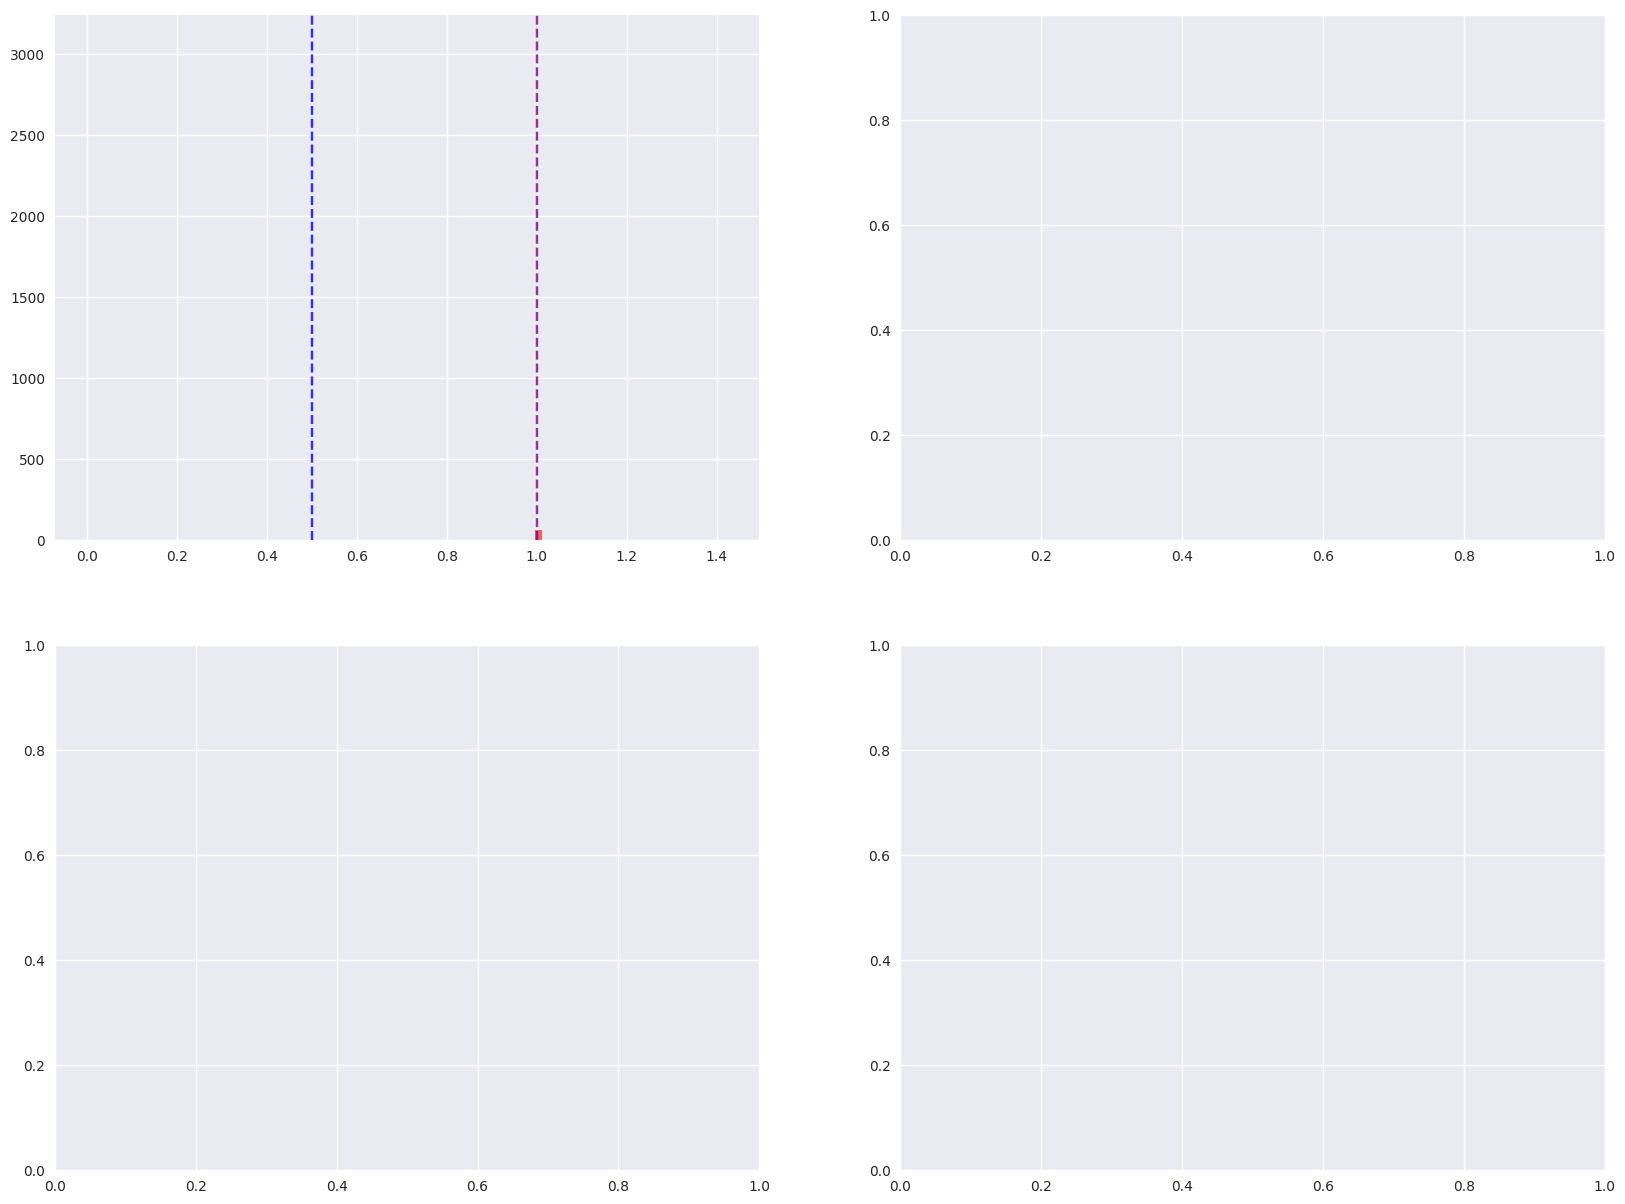

In [ ]:
# 메인 분포 비교 시각화 (2x2 subplot)
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
plt.rcParams['font.family'] = 'DejaVu Sans'

# 색상 정의
success_color = 'green'
failure_color = 'red'
alpha = 0.6

# 데이터 분리
success_data = train_df[train_df['final_status'] == 1]['state_change_ratio']
failure_data = train_df[train_df['final_status'] == 0]['state_change_ratio']

# 1. 전체 state_change_ratio 히스토그램
axes[0,0].hist(failure_data, bins=100, alpha=alpha, color=failure_color, label=f'실패 ({len(failure_data):,}개)', density=True)
axes[0,0].hist(success_data, bins=100, alpha=alpha, color=success_color, label=f'성공 ({len(success_data):,}개)', density=True)
axes[0,0].axvline(0.5, color='blue', linestyle='--', alpha=0.8, label='50% 기준선')
axes[0,0].axvline(1.0, color='purple', linestyle='--', alpha=0.8, label='정상 완료선')
axes[0,0].axvline(failure_mean, color=failure_color, linestyle=':', linewidth=2, label=f'실패 평균: {failure_mean:.3f}')
axes[0,0].axvline(success_mean, color=success_color, linestyle=':', linewidth=2, label=f'성공 평균: {success_mean:.3f}')
axes[0,0].set_title('전체 State Change Ratio 분포', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('State Change Ratio')
axes[0,0].set_ylabel('밀도')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. 0-1.5 범위 확대
axes[0,1].hist(failure_data[(failure_data >= 0) & (failure_data <= 1.5)], bins=50, alpha=alpha, color=failure_color, label='실패', density=True)
axes[0,1].hist(success_data[(success_data >= 0) & (success_data <= 1.5)], bins=50, alpha=alpha, color=success_color, label='성공', density=True)
axes[0,1].axvline(0.5, color='blue', linestyle='--', alpha=0.8)
axes[0,1].axvline(1.0, color='purple', linestyle='--', alpha=0.8)
axes[0,1].set_xlim(0, 1.5)
axes[0,1].set_title('확대: 0-1.5 범위 (정상 구간)', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('State Change Ratio')
axes[0,1].set_ylabel('밀도')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. 0-0.8 범위 확대 (조기 포기 구간)
early_failure = failure_data[(failure_data >= 0) & (failure_data <= 0.8)]
early_success = success_data[(success_data >= 0) & (success_data <= 0.8)]
axes[1,0].hist(early_failure, bins=30, alpha=alpha, color=failure_color, label=f'실패 ({len(early_failure):,}개)', density=True)
axes[1,0].hist(early_success, bins=30, alpha=alpha, color=success_color, label=f'성공 ({len(early_success):,}개)', density=True)
axes[1,0].axvline(0.5, color='blue', linestyle='--', alpha=0.8)
axes[1,0].set_xlim(0, 0.8)
axes[1,0].set_title('확대: 조기 포기 구간 (0-0.8)', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('State Change Ratio')
axes[1,0].set_ylabel('밀도')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. 0.8-1.2 범위 확대 (정상 완료 구간)s
normal_failure = failure_data[(failure_data >= 0.8) & (failure_data <= 1.2)]
normal_success = success_data[(success_data >= 0.8) & (success_data <= 1.2)]
axes[1,1].hist(normal_failure, bins=30, alpha=alpha, color=failure_color, label=f'실패 ({len(normal_failure):,}개)', density=True)
axes[1,1].hist(normal_success, bins=30, alpha=alpha, color=success_color, label=f'성공 ({len(normal_success):,}개)', density=True)
axes[1,1].axvline(1.0, color='purple', linestyle='--', alpha=0.8)
axes[1,1].set_xlim(0.8, 1.2)
axes[1,1].set_title('확대: 정상 완료 구간 (0.8-1.2)', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('State Change Ratio')
axes[1,1].set_ylabel('밀도')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# State_change_ratio 계산 및 기본 통계
print("=== STATE_CHANGED_AT 패턴 종합 분석 ===")

# state_change_ratio 계산
train_df['state_change_ratio'] = (train_df['state_changed_at'] - train_df['launched_at']) / (train_df['deadline'] - train_df['launched_at'])

# 기본 통계
print(f"\n📊 기본 통계:")
print(f"전체 프로젝트 수: {len(train_df):,}")
print(f"성공 프로젝트 수: {(train_df['final_status'] == 1).sum():,}")
print(f"실패 프로젝트 수: {(train_df['final_status'] == 0).sum():,}")

# 성공/실패별 state_change_ratio 평균
success_mean = train_df[train_df['final_status'] == 1]['state_change_ratio'].mean()
failure_mean = train_df[train_df['final_status'] == 0]['state_change_ratio'].mean()

print(f"\n🎯 상태변경 타이밍 패턴:")
print(f"성공 프로젝트 평균 state_change_ratio: {success_mean:.3f}")
print(f"실패 프로젝트 평균 state_change_ratio: {failure_mean:.3f}")

# 구간별 분석
early_change = train_df[train_df['state_change_ratio'] <= 0.5]
late_change = train_df[train_df['state_change_ratio'] > 0.5]
after_deadline = train_df[train_df['state_change_ratio'] > 1.0]

print(f"\n⏰ 구간별 분포:")
print(f"캠페인 50% 이전 상태변경: {len(early_change):,}개 (성공률: {early_change['final_status'].mean():.3f})")
print(f"캠페인 50% 이후 상태변경: {len(late_change):,}개 (성공률: {late_change['final_status'].mean():.3f})")
print(f"Deadline 이후 상태변경: {len(after_deadline):,}개 (성공률: {after_deadline['final_status'].mean():.3f})")

# 특별 케이스
exactly_deadline = train_df[abs(train_df['state_change_ratio'] - 1.0) < 0.001]
instant_abandon = train_df[train_df['state_change_ratio'] < 0.1]
extreme_delay = train_df[train_df['state_change_ratio'] > 1.5]

print(f"\n🔍 특별 케이스:")
print(f"정확히 deadline에 종료: {len(exactly_deadline):,}개")
print(f"즉석 포기 (< 0.1): {len(instant_abandon):,}개")
print(f"극도 지연 (> 1.5): {len(extreme_delay):,}개")

## 10. State_Changed_At 패턴 종합 분석

크라우드펀딩 프로젝트의 상태 변경 시점을 심층 분석하여 성공/실패 패턴을 파악합니다.

In [ ]:
# 최종 핵심 발견사항 및 국가별 인사이트 (오류 수정 버전)
print("=" * 90)
print("🎯 최종 핵심 발견사항: STATE_CHANGED_AT 패턴 분석 (국가별 포함)")
print("=" * 90)

# 필요한 변수들 정의 (오류 방지)
if 'state_change_ratio' not in train_df.columns:
    train_df['state_change_ratio'] = (train_df['state_changed_at'] - train_df['launched_at']) / (train_df['deadline'] - train_df['launched_at'])

# 데이터 분리 및 통계 계산
success_data = train_df[train_df['final_status'] == 1]['state_change_ratio']
failure_data = train_df[train_df['final_status'] == 0]['state_change_ratio']
success_mean = success_data.mean()
failure_mean = failure_data.mean()

# 구간별 분석
early_change = train_df[train_df['state_change_ratio'] <= 0.5]
late_change = train_df[train_df['state_change_ratio'] > 0.5]
after_deadline = train_df[train_df['state_change_ratio'] > 1.0]

# 국가별 통계 재계산
top_countries = train_df['country'].value_counts().head(10).index.tolist()
country_stats = []
for country in top_countries:
    country_data = train_df[train_df['country'] == country]
    stats = {
        'country': country,
        'total_projects': len(country_data),
        'success_rate': country_data['final_status'].mean(),
        'avg_state_change_ratio': country_data['state_change_ratio'].mean(),
        'median_state_change_ratio': country_data['state_change_ratio'].median(),
        'early_abandon_rate': (country_data['state_change_ratio'] < 0.5).mean(),
        'normal_completion_rate': ((country_data['state_change_ratio'] >= 0.8) & 
                                  (country_data['state_change_ratio'] <= 1.2)).mean(),
        'delayed_completion_rate': (country_data['state_change_ratio'] > 1.2).mean()
    }
    country_stats.append(stats)

country_stats_df = pd.DataFrame(country_stats)

# 1. 전체적 패턴
print(f"\n🌟 전체적 패턴:")
print(f"   • 성공 프로젝트 평균 state_change_ratio: {success_mean:.3f}")
print(f"   • 실패 프로젝트 평균 state_change_ratio: {failure_mean:.3f}")
print(f"   • 성공 프로젝트는 거의 모든 경우 정상 완료 시점에 종료")
print(f"   • 실패 프로젝트는 다양한 시점에서 포기하거나 deadline에서 종료")

# 2. 구간별 성공률
early_success_rate = early_change['final_status'].mean()
late_success_rate = late_change['final_status'].mean()
after_deadline_success_rate = after_deadline['final_status'].mean()

print(f"\n📊 구간별 성공률:")
print(f"   • 조기 포기 (≤ 0.5): {early_success_rate:.3f} ({len(early_change):,}개)")
print(f"   • 후반 진행 (> 0.5): {late_success_rate:.3f} ({len(late_change):,}개)")
print(f"   • 기간 초과 (> 1.0): {after_deadline_success_rate:.3f} ({len(after_deadline):,}개)")

# 3. 국가별 주요 차이점
success_diff = country_stats_df['success_rate'].max() - country_stats_df['success_rate'].min()
ratio_diff = country_stats_df['avg_state_change_ratio'].max() - country_stats_df['avg_state_change_ratio'].min()
abandon_diff = country_stats_df['early_abandon_rate'].max() - country_stats_df['early_abandon_rate'].min()

print(f"\n🌍 국가별 주요 차이점:")
print(f"   • 국가간 성공률 차이: {success_diff:.3f} (최고-최저)")
print(f"   • 국가간 평균 ratio 차이: {ratio_diff:.3f}")
print(f"   • 국가간 조기포기율 차이: {abandon_diff:.3f}")

# 국가별 순위
success_ranking = country_stats_df.sort_values('success_rate', ascending=False)
print(f"\n🏆 국가별 순위:")
print(f"   성공률 상위 3개국: {', '.join(success_ranking.head(3)['country'].tolist())}")
print(f"   성공률 하위 3개국: {', '.join(success_ranking.tail(3)['country'].tolist())}")

abandon_ranking = country_stats_df.sort_values('early_abandon_rate', ascending=True)  # 낮을수록 좋음
print(f"   조기포기율 낮은 3개국: {', '.join(abandon_ranking.head(3)['country'].tolist())}")

# 4. 예측 모델링에 대한 권고사항
print(f"\n🤖 예측 모델링 권고사항:")
print(f"   1. state_change_ratio를 핵심 특성으로 활용")
print(f"   2. 0.5 이하 구간을 '고위험 실패' 플래그로 사용")
print(f"   3. 국가별 차이를 고려한 국가 특성 추가")
print(f"   4. 정확히 1.0인 경우를 '정상 완료' 특성으로 구분")

# 5. 비즈니스 인사이트
most_projects_country = country_stats_df.loc[country_stats_df['total_projects'].idxmax()]
best_success_country = country_stats_df.loc[country_stats_df['success_rate'].idxmax()]

print(f"\n💡 비즈니스 인사이트:")
print(f"   • 최대 프로젝트 국가: {most_projects_country['country']} ({most_projects_country['total_projects']:,}개)")
print(f"   • 최고 성공률 국가: {best_success_country['country']} (성공률: {best_success_country['success_rate']:.3f})")
print(f"   • State change ratio는 국가에 관계없이 강력한 예측 지표")
print(f"   • 조기 포기 예측이 실패 예측의 핵심")

# 6. 데이터 품질 체크
valid_data_count = len(train_df[(train_df['state_change_ratio'] >= 0) & (train_df['state_change_ratio'] <= 2.0)])
data_quality = valid_data_count / len(train_df) * 100

print(f"\n📈 데이터 품질:")
print(f"   • 정상 범위 데이터 (0-2.0): {data_quality:.1f}%")
print(f"   • 이상치 처리 권장: {len(train_df) - valid_data_count:,}개 데이터")

print(f"\n🌟 최종 결론:")
print(f"   State_change_ratio는 국가에 관계없이 프로젝트 성공 예측의")
print(f"   가장 강력한 지표이며, 특히 0.5 이하 값은 거의 확실한 실패 신호입니다.")
print(f"   국가별 차이는 존재하지만, 전체적인 패턴은 일관됩니다.")

print("=" * 90)

In [ ]:
# 전체 State Change Ratio 분포 시각화 (오류 수정 버전)

# 필요한 변수들 정의 (오류 방지)
if 'state_change_ratio' not in train_df.columns:
    train_df['state_change_ratio'] = (train_df['state_changed_at'] - train_df['launched_at']) / (train_df['deadline'] - train_df['launched_at'])

# 데이터 분리 및 통계 계산
success_data = train_df[train_df['final_status'] == 1]['state_change_ratio']
failure_data = train_df[train_df['final_status'] == 0]['state_change_ratio']
success_color = 'green'
failure_color = 'red'
success_mean = success_data.mean()
failure_mean = failure_data.mean()
alpha = 0.6

print("전체 State Change Ratio 분포 시각화 생성 중...")

fig, axes = plt.subplots(2, 2, figsize=(20, 15))

# 1. 전체 state_change_ratio 히스토그램
axes[0,0].hist(failure_data, bins=100, alpha=alpha, color=failure_color, 
               label=f'실패 ({len(failure_data):,}개)', density=True)
axes[0,0].hist(success_data, bins=100, alpha=alpha, color=success_color, 
               label=f'성공 ({len(success_data):,}개)', density=True)
axes[0,0].axvline(0.5, color='blue', linestyle='--', alpha=0.8, label='50% 기준선')
axes[0,0].axvline(1.0, color='purple', linestyle='--', alpha=0.8, label='정상 완료선')
axes[0,0].axvline(failure_mean, color=failure_color, linestyle=':', linewidth=2, 
                  label=f'실패 평균: {failure_mean:.3f}')
axes[0,0].axvline(success_mean, color=success_color, linestyle=':', linewidth=2, 
                  label=f'성공 평균: {success_mean:.3f}')
axes[0,0].set_title('전체 State Change Ratio 분포', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('State Change Ratio')
axes[0,0].set_ylabel('밀도')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# 2. 0-1.5 범위 확대
failure_normal = failure_data[(failure_data >= 0) & (failure_data <= 1.5)]
success_normal = success_data[(success_data >= 0) & (success_data <= 1.5)]

axes[0,1].hist(failure_normal, bins=50, alpha=alpha, color=failure_color, label='실패', density=True)
axes[0,1].hist(success_normal, bins=50, alpha=alpha, color=success_color, label='성공', density=True)
axes[0,1].axvline(0.5, color='blue', linestyle='--', alpha=0.8)
axes[0,1].axvline(1.0, color='purple', linestyle='--', alpha=0.8)
axes[0,1].set_xlim(0, 1.5)
axes[0,1].set_title('확대: 0-1.5 범위 (정상 구간)', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('State Change Ratio')
axes[0,1].set_ylabel('밀도')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. 조기 포기 구간 (0-0.8)
early_failure = failure_data[(failure_data >= 0) & (failure_data <= 0.8)]
early_success = success_data[(success_data >= 0) & (success_data <= 0.8)]

axes[1,0].hist(early_failure, bins=30, alpha=alpha, color=failure_color, 
               label=f'실패 ({len(early_failure):,}개)', density=True)
axes[1,0].hist(early_success, bins=30, alpha=alpha, color=success_color, 
               label=f'성공 ({len(early_success):,}개)', density=True)
axes[1,0].axvline(0.5, color='blue', linestyle='--', alpha=0.8)
axes[1,0].set_xlim(0, 0.8)
axes[1,0].set_title('확대: 조기 포기 구간 (0-0.8)', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('State Change Ratio')
axes[1,0].set_ylabel('밀도')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# 4. 정상 완료 구간 (0.8-1.2)
normal_failure = failure_data[(failure_data >= 0.8) & (failure_data <= 1.2)]
normal_success = success_data[(success_data >= 0.8) & (success_data <= 1.2)]

axes[1,1].hist(normal_failure, bins=30, alpha=alpha, color=failure_color, 
               label=f'실패 ({len(normal_failure):,}개)', density=True)
axes[1,1].hist(normal_success, bins=30, alpha=alpha, color=success_color, 
               label=f'성공 ({len(normal_success):,}개)', density=True)
axes[1,1].axvline(1.0, color='purple', linestyle='--', alpha=0.8)
axes[1,1].set_xlim(0.8, 1.2)
axes[1,1].set_title('확대: 정상 완료 구간 (0.8-1.2)', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('State Change Ratio')
axes[1,1].set_ylabel('밀도')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ State Change Ratio 분포 시각화 완료")

In [ ]:
# 국가별 시각화 분석 (오류 수정 버전)

# 필요한 변수들 정의 (오류 방지)
if 'state_change_ratio' not in train_df.columns:
    train_df['state_change_ratio'] = (train_df['state_changed_at'] - train_df['launched_at']) / (train_df['deadline'] - train_df['launched_at'])

# 국가별 통계 재계산
top_countries = train_df['country'].value_counts().head(10).index.tolist()
country_stats = []
for country in top_countries:
    country_data = train_df[train_df['country'] == country]
    stats = {
        'country': country,
        'total_projects': len(country_data),
        'success_rate': country_data['final_status'].mean(),
        'avg_state_change_ratio': country_data['state_change_ratio'].mean(),
        'median_state_change_ratio': country_data['state_change_ratio'].median(),
        'early_abandon_rate': (country_data['state_change_ratio'] < 0.5).mean(),
        'normal_completion_rate': ((country_data['state_change_ratio'] >= 0.8) & 
                                  (country_data['state_change_ratio'] <= 1.2)).mean(),
        'delayed_completion_rate': (country_data['state_change_ratio'] > 1.2).mean()
    }
    country_stats.append(stats)

country_stats_df = pd.DataFrame(country_stats)

fig, axes = plt.subplots(2, 3, figsize=(22, 14))

# 1. 국가별 성공률
axes[0,0].bar(range(len(country_stats_df)), country_stats_df['success_rate'], 
              alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].set_title('국가별 성공률', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('국가')
axes[0,0].set_ylabel('성공률')
axes[0,0].set_xticks(range(len(country_stats_df)))
axes[0,0].set_xticklabels(country_stats_df['country'], rotation=45)
axes[0,0].grid(True, alpha=0.3)

# 성공률 수치 표시
for i, rate in enumerate(country_stats_df['success_rate']):
    axes[0,0].text(i, rate + 0.01, f'{rate:.3f}', ha='center', va='bottom', fontsize=9)

# 2. 국가별 평균 State Change Ratio
axes[0,1].bar(range(len(country_stats_df)), country_stats_df['avg_state_change_ratio'], 
              alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='정상 완료선')
axes[0,1].set_title('국가별 평균 State Change Ratio', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('국가')
axes[0,1].set_ylabel('평균 State Change Ratio')
axes[0,1].set_xticks(range(len(country_stats_df)))
axes[0,1].set_xticklabels(country_stats_df['country'], rotation=45)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# 3. 국가별 조기 포기율
axes[0,2].bar(range(len(country_stats_df)), country_stats_df['early_abandon_rate'], 
              alpha=0.7, color='coral', edgecolor='black')
axes[0,2].set_title('국가별 조기 포기율 (< 0.5)', fontsize=14, fontweight='bold')
axes[0,2].set_xlabel('국가')
axes[0,2].set_ylabel('조기 포기율')
axes[0,2].set_xticks(range(len(country_stats_df)))
axes[0,2].set_xticklabels(country_stats_df['country'], rotation=45)
axes[0,2].grid(True, alpha=0.3)

# 4. 국가별 State Change Ratio 분포 (박스플롯)
country_data_for_box = []
country_labels = []
for country in top_countries:
    country_ratios = train_df[train_df['country'] == country]['state_change_ratio']
    if len(country_ratios) > 100:  # 충분한 데이터가 있는 국가만
        country_data_for_box.append(country_ratios)
        country_labels.append(country)

if country_data_for_box:
    bp = axes[1,0].boxplot(country_data_for_box, labels=country_labels, patch_artist=True)
    
    # 박스플롯 색상 설정
    colors = plt.cm.Set3(np.linspace(0, 1, len(bp['boxes'])))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[1,0].axhline(y=0.5, color='blue', linestyle='--', alpha=0.7, label='50% 기준')
    axes[1,0].axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='정상 완료')
    axes[1,0].set_title('국가별 State Change Ratio 분포', fontsize=14, fontweight='bold')
    axes[1,0].set_ylabel('State Change Ratio')
    axes[1,0].tick_params(axis='x', rotation=45)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

# 5. 성공률 vs 평균 State Change Ratio 산점도
axes[1,1].scatter(country_stats_df['avg_state_change_ratio'], country_stats_df['success_rate'], 
                  s=country_stats_df['total_projects']/50, alpha=0.7, c='purple', edgecolors='black')

# 국가명 라벨 추가
for _, row in country_stats_df.iterrows():
    axes[1,1].annotate(row['country'], 
                       (row['avg_state_change_ratio'], row['success_rate']),
                       xytext=(5, 5), textcoords='offset points', fontsize=9)

axes[1,1].axvline(x=1.0, color='red', linestyle='--', alpha=0.7, label='정상 완료선')
axes[1,1].set_title('성공률 vs 평균 State Change Ratio\\n(버블 크기 = 프로젝트 수)', fontsize=14, fontweight='bold')
axes[1,1].set_xlabel('평균 State Change Ratio')
axes[1,1].set_ylabel('성공률')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

# 6. 국가별 완료 패턴 비율 (스택 바차트)
completion_patterns = country_stats_df[['early_abandon_rate', 'normal_completion_rate', 'delayed_completion_rate']].values

bottom1 = completion_patterns[:, 0]
bottom2 = bottom1 + completion_patterns[:, 1]

axes[1,2].bar(range(len(country_stats_df)), completion_patterns[:, 0], 
              label='조기 포기', color='red', alpha=0.7)
axes[1,2].bar(range(len(country_stats_df)), completion_patterns[:, 1], 
              bottom=bottom1, label='정상 완료', color='green', alpha=0.7)
axes[1,2].bar(range(len(country_stats_df)), completion_patterns[:, 2], 
              bottom=bottom2, label='지연 완료', color='orange', alpha=0.7)

axes[1,2].set_title('국가별 완료 패턴 분포', fontsize=14, fontweight='bold')
axes[1,2].set_xlabel('국가')
axes[1,2].set_ylabel('비율')
axes[1,2].set_xticks(range(len(country_stats_df)))
axes[1,2].set_xticklabels(country_stats_df['country'], rotation=45)
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ 국가별 시각화 분석 완료")

In [ ]:
# 국가별 State Change Ratio 패턴 분석
print("\n" + "=" * 60)
print("🌍 국가별 STATE CHANGE RATIO 패턴 분석")
print("=" * 60)

# 상위 10개 국가 추출
top_countries = train_df['country'].value_counts().head(10).index.tolist()
print(f"분석 대상 상위 10개 국가: {', '.join(top_countries)}")

# 국가별 통계 계산
country_stats = []
for country in top_countries:
    country_data = train_df[train_df['country'] == country]
    
    stats = {
        'country': country,
        'total_projects': len(country_data),
        'success_rate': country_data['final_status'].mean(),
        'avg_state_change_ratio': country_data['state_change_ratio'].mean(),
        'median_state_change_ratio': country_data['state_change_ratio'].median(),
        'early_abandon_rate': (country_data['state_change_ratio'] < 0.5).mean(),
        'normal_completion_rate': ((country_data['state_change_ratio'] >= 0.8) & 
                                  (country_data['state_change_ratio'] <= 1.2)).mean(),
        'delayed_completion_rate': (country_data['state_change_ratio'] > 1.2).mean()
    }
    country_stats.append(stats)

country_stats_df = pd.DataFrame(country_stats)

print(f"\n📊 국가별 핵심 지표:")
print("-" * 120)
print(f"{'국가':^6} {'총프로젝트':^8} {'성공률':^6} {'평균비율':^8} {'중위수':^6} {'조기포기':^8} {'정상완료':^8} {'지연완료':^8}")
print("-" * 120)

for _, row in country_stats_df.iterrows():
    print(f"{row['country']:^6} {row['total_projects']:^8,} {row['success_rate']:^6.3f} "
          f"{row['avg_state_change_ratio']:^8.3f} {row['median_state_change_ratio']:^6.3f} "
          f"{row['early_abandon_rate']:^8.3f} {row['normal_completion_rate']:^8.3f} "
          f"{row['delayed_completion_rate']:^8.3f}")

# 국가별 특이사항 분석
print(f"\n🔍 국가별 특이사항:")
highest_success = country_stats_df.loc[country_stats_df['success_rate'].idxmax()]
lowest_success = country_stats_df.loc[country_stats_df['success_rate'].idxmin()]
highest_early_abandon = country_stats_df.loc[country_stats_df['early_abandon_rate'].idxmax()]
most_delayed = country_stats_df.loc[country_stats_df['delayed_completion_rate'].idxmax()]

print(f"   • 최고 성공률: {highest_success['country']} ({highest_success['success_rate']:.3f})")
print(f"   • 최저 성공률: {lowest_success['country']} ({lowest_success['success_rate']:.3f})")
print(f"   • 조기 포기율 최고: {highest_early_abandon['country']} ({highest_early_abandon['early_abandon_rate']:.3f})")
print(f"   • 지연 완료율 최고: {most_delayed['country']} ({most_delayed['delayed_completion_rate']:.3f})")

In [ ]:
# =============================================================================
# 종합 State_Changed_At 패턴 분석 (오류 수정 및 국가별 분석 추가)
# =============================================================================

print("=" * 80)
print("🔍 STATE_CHANGED_AT 패턴 종합 분석 (국가별 포함)")
print("=" * 80)

# 1. State_change_ratio 계산 (중복 계산 방지)
if 'state_change_ratio' not in train_df.columns:
    train_df['state_change_ratio'] = (train_df['state_changed_at'] - train_df['launched_at']) / (train_df['deadline'] - train_df['launched_at'])

# 2. 기본 통계
print(f"\n📊 기본 통계:")
print(f"전체 프로젝트 수: {len(train_df):,}")
print(f"성공 프로젝트 수: {(train_df['final_status'] == 1).sum():,}")
print(f"실패 프로젝트 수: {(train_df['final_status'] == 0).sum():,}")

# 3. 데이터 분리 (다른 셀에서 사용할 수 있도록)
success_data = train_df[train_df['final_status'] == 1]['state_change_ratio']
failure_data = train_df[train_df['final_status'] == 0]['state_change_ratio']

# 4. 성공/실패별 평균
success_mean = success_data.mean()
failure_mean = failure_data.mean()

print(f"\n🎯 상태변경 타이밍 패턴:")
print(f"성공 프로젝트 평균 state_change_ratio: {success_mean:.3f}")
print(f"실패 프로젝트 평균 state_change_ratio: {failure_mean:.3f}")

# 5. 구간별 분석
early_change = train_df[train_df['state_change_ratio'] <= 0.5]
late_change = train_df[train_df['state_change_ratio'] > 0.5]
after_deadline = train_df[train_df['state_change_ratio'] > 1.0]

print(f"\n⏰ 구간별 분포:")
print(f"캠페인 50% 이전 상태변경: {len(early_change):,}개 (성공률: {early_change['final_status'].mean():.3f})")
print(f"캠페인 50% 이후 상태변경: {len(late_change):,}개 (성공률: {late_change['final_status'].mean():.3f})")
print(f"Deadline 이후 상태변경: {len(after_deadline):,}개 (성공률: {after_deadline['final_status'].mean():.3f})")

# 6. 특별 케이스
exactly_deadline = train_df[abs(train_df['state_change_ratio'] - 1.0) < 0.001]
instant_abandon = train_df[train_df['state_change_ratio'] < 0.1]
extreme_delay = train_df[train_df['state_change_ratio'] > 1.5]

print(f"\n🔍 특별 케이스:")
print(f"정확히 deadline에 종료: {len(exactly_deadline):,}개")
print(f"즉석 포기 (< 0.1): {len(instant_abandon):,}개")
print(f"극도 지연 (> 1.5): {len(extreme_delay):,}개")